# Predcition of Hospital Admission Related to Otitis Media

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to otitis media (otmedia).

In [85]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [86]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [87]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [88]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [89]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'otmedia_date_'+str(i), 'otmedia_ab_date_'+str(i), 'otmedia_ab_type_'+str(i),
                   'incdt_otmedia_date_'+str(i), 'admitted_otmedia_date_'+str(i), 'sgss_gp_cov_otmedia_date_'+str(i)]]
    
    #drop rows with no otmedia reord
    datum = datum[datum['otmedia_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with otmedia_i
    datum = datum[datum['sgss_gp_cov_otmedia_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'otmedia_date_'+str(i): 'otmedia_date', 'otmedia_ab_date_'+str(i): 'otmedia_ab_date', 
                           'otmedia_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_otmedia_date_'+str(i): 'incdt_otmedia_date', 'incdt_otmedia_type_'+str(i): 'incdt_otmedia_type',
                           'admitted_otmedia_date_'+str(i): 'admitted_otmedia_date',
                           'sgss_gp_cov_otmedia_date_'+str(i): 'sgss_gp_cov_otmedia_date'},
                inplace=True)
    
    return datum

In [90]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_otmedia_admitted', 'duration_otmedia_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [91]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [92]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [93]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [94]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):

    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [95]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [96]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [97]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [98]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + otmedia_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [99]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [100]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + otmedia_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [101]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + otmedia_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [102]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_otmedia.csv.gz')

data.shape

(200000, 224)

In [103]:
# save model outputs
a = open("../output/hospitalisation_prediction_otmedia/data_otmedia_record_cph_otmedia.txt", "w")
a.write("")
a.writelines(['data_otmedia_1 #with a record, #with no record: %.0f' % (data['otmedia_date_1'].notna().sum()), ', %.0f' % (data['otmedia_date_1'].isna().sum()),
              '\ndata_otmedia_2 #with a record, #with no record: %.0f' % (data['otmedia_date_2'].notna().sum()), ', %.0f' % (data['otmedia_date_2'].isna().sum()),
              '\ndata_otmedia_3 #with a record, #with no record: %.0f' % (data['otmedia_date_3'].notna().sum()), ', %.0f' % (data['otmedia_date_3'].isna().sum()),
              '\ndata_otmedia_4 #with a record, #with no record: %.0f' % (data['otmedia_date_4'].notna().sum()), ', %.0f' % (data['otmedia_date_4'].isna().sum()),
              '\ndata_otmedia_5 #with a record, #with no record: %.0f' % (data['otmedia_date_5'].notna().sum()), ', %.0f' % (data['otmedia_date_5'].isna().sum()),
              '\ndata_otmedia_6 #with a record, #with no record: %.0f' % (data['otmedia_date_6'].notna().sum()), ', %.0f' % (data['otmedia_date_6'].isna().sum()),
              '\ndata_otmedia_7 #with a record, #with no record: %.0f' % (data['otmedia_date_7'].notna().sum()), ', %.0f' % (data['otmedia_date_7'].isna().sum()),
              '\ndata_otmedia_8 #with a record, #with no record: %.0f' % (data['otmedia_date_8'].notna().sum()), ', %.0f' % (data['otmedia_date_8'].isna().sum()),
              '\ndata_otmedia_9 #with a record, #with no record: %.0f' % (data['otmedia_date_9'].notna().sum()), ', %.0f' % (data['otmedia_date_9'].isna().sum()),
              '\ndata_otmedia_10 #with a record, #with no record: %.0f' % (data['otmedia_date_10'].notna().sum()), ', %.0f' % (data['otmedia_date_10'].isna().sum()),
              '\ndata_otmedia_11 #with a record, #with no record: %.0f' % (data['otmedia_date_11'].notna().sum()), ', %.0f' % (data['otmedia_date_11'].isna().sum()),
              '\ndata_otmedia_12 #with a record, #with no record: %.0f' % (data['otmedia_date_12'].notna().sum()), ', %.0f' % (data['otmedia_date_12'].isna().sum()),
              '\ndata_otmedia_13 #with a record, #with no record: %.0f' % (data['otmedia_date_13'].notna().sum()), ', %.0f' % (data['otmedia_date_13'].isna().sum()),
              '\ndata_otmedia_14 #with a record, #with no record: %.0f' % (data['otmedia_date_14'].notna().sum()), ', %.0f' % (data['otmedia_date_14'].isna().sum()),
              '\ndata_otmedia_15 #with a record, #with no record: %.0f' % (data['otmedia_date_15'].notna().sum()), ', %.0f' % (data['otmedia_date_15'].isna().sum()),
              '\ndata_otmedia_16 #with a record, #with no record: %.0f' % (data['otmedia_date_16'].notna().sum()), ', %.0f' % (data['otmedia_date_16'].isna().sum()),
              '\ndata_otmedia_17 #with a record, #with no record: %.0f' % (data['otmedia_date_17'].notna().sum()), ', %.0f' % (data['otmedia_date_17'].isna().sum()),
              '\ndata_otmedia_18 #with a record, #with no record: %.0f' % (data['otmedia_date_18'].notna().sum()), ', %.0f' % (data['otmedia_date_18'].isna().sum()),
              '\ndata_otmedia_19 #with a record, #with no record: %.0f' % (data['otmedia_date_19'].notna().sum()), ', %.0f' % (data['otmedia_date_19'].isna().sum()),
              '\ndata_otmedia_20 #with a record, #with no record: %.0f' % (data['otmedia_date_20'].notna().sum()), ', %.0f' % (data['otmedia_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [104]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

1.0     37087
0.0     37079
2.0     32940
3.0     24827
4.0     14896
6.0     12180
7.0     10039
5.0      8387
8.0      8009
9.0      5819
10.0     3376
11.0     1795
12.0     1409
13.0      860
14.0      552
15.0      346
16.0      188
17.0      128
18.0       52
19.0       19
20.0        9
22.0        2
21.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [105]:
#read 20 otmedias and concatenate them 
data_otmedia_1 = proc_infec_data(data,1)
data_otmedia_2 = proc_infec_data(data,2)
data_otmedia_3 = proc_infec_data(data,3)
data_otmedia_4 = proc_infec_data(data,4)
data_otmedia_5 = proc_infec_data(data,5)
data_otmedia_6 = proc_infec_data(data,6)
data_otmedia_7 = proc_infec_data(data,7)
data_otmedia_8 = proc_infec_data(data,8)
data_otmedia_9 = proc_infec_data(data,9)
data_otmedia_10 = proc_infec_data(data,10)
data_otmedia_11 = proc_infec_data(data,11)
data_otmedia_12 = proc_infec_data(data,12)
data_otmedia_13 = proc_infec_data(data,13)
data_otmedia_14 = proc_infec_data(data,14)
data_otmedia_15 = proc_infec_data(data,15)
data_otmedia_16 = proc_infec_data(data,16)
data_otmedia_17 = proc_infec_data(data,17)
data_otmedia_18 = proc_infec_data(data,18)
data_otmedia_19 = proc_infec_data(data,19)
data_otmedia_20 = proc_infec_data(data,20)

data_otmedia = pd.concat([data_otmedia_1, data_otmedia_2, data_otmedia_3, data_otmedia_4, data_otmedia_5, data_otmedia_6, data_otmedia_7, data_otmedia_8, data_otmedia_9, data_otmedia_10, data_otmedia_11, data_otmedia_12, data_otmedia_13, data_otmedia_14, data_otmedia_15, data_otmedia_16, data_otmedia_17, data_otmedia_18, data_otmedia_19, data_otmedia_20])
data_otmedia.reset_index(inplace=True, drop=True)
data_otmedia.shape

(359888, 20)

### 2-2- add season, event, and duration variables
#### season

In [106]:
# convert data types
data_otmedia['otmedia_date'] = data_otmedia['otmedia_date'].astype('datetime64[ns]')
data_otmedia['admitted_otmedia_date'] = data_otmedia['admitted_otmedia_date'].astype('datetime64[ns]')
data_otmedia.died_date = data_otmedia.died_date.astype('datetime64[ns]')
data_otmedia.deregistered_date = data_otmedia.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_otmedia['date'] = data_otmedia['otmedia_date'] #gp_cons_otmedia
data_otmedia['date'] = data_otmedia['date'].dt.strftime('%Y-%m')
print(f'min date: {data_otmedia.date.min()}')
print(f'max date: {data_otmedia.date.max()}')
print(f'length of data_otmedia: {len(data_otmedia)}')

min date: 2019-01
max date: 2022-11
length of data_otmedia: 359888


In [107]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_otmedia with today's date in year and month
data_otmedia = data_otmedia[data_otmedia['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_otmedia = data_otmedia[data_otmedia['date'] != last_1_month_date_y_m]
data_otmedia = data_otmedia[data_otmedia['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of otmedia records
data_otmedia['season'] = np.nan
data_otmedia['date_month'] = pd.DatetimeIndex(data_otmedia['date']).month

conditions = [
    (data_otmedia['date_month'] >= 3) & (data_otmedia['date_month'] <= 5),
    (data_otmedia['date_month'] >= 6) & (data_otmedia['date_month'] <= 8),
    (data_otmedia['date_month'] >= 9) & (data_otmedia['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_otmedia['season'] = np.select(conditions, choices, default='winter')

print(data_otmedia['season'].value_counts())
print(f'\nmin date: {data_otmedia.date.min()}')
print(f'max date: {data_otmedia.date.max()}')
print(f'length: {len(data_otmedia)}')

summer    93211
spring    92900
winter    83404
autumn    69146
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 338661


In [108]:
# data_otmedia = data_otmedia[data_otmedia['date'] <= '2019-12']
# data_otmedia = data_otmedia[(data_otmedia['date'] >= '2020-03') & (data_otmedia['date']<= '2021-03')]
# data_otmedia = data_otmedia[data_otmedia['date'] >= '2021-04']
# print(f'min date: {data_otmedia.date.min()}')
# print(f'max date: {data_otmedia.date.max()}')

In [109]:
#add period variable
data_otmedia.loc[(data_otmedia['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_otmedia.loc[((data_otmedia['date'] >= '2020-01') & (data_otmedia['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_otmedia.loc[(data_otmedia['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [110]:
#scenario 1
#not hosped (nothing happened)
#data_otmedia = data_otmedia[data_otmedia['admitted_otmedia_date'].notnull()]
data_otmedia.loc[data_otmedia['admitted_otmedia_date'].isnull(), 'event_otmedia_admitted'] = 0
data_otmedia['event_otmedia_admitted'].value_counts()

0.0    237173
Name: event_otmedia_admitted, dtype: int64

In [111]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_otmedia['delta_otmedia_admitted'] = (data_otmedia['admitted_otmedia_date'] - data_otmedia['otmedia_date']).dt.days
data_otmedia['delta_otmedia_admitted'] = (data_otmedia['admitted_otmedia_date'] - data_otmedia['otmedia_date']).dt.days #gp_cons_otmedia
data_otmedia.loc[((data_otmedia['delta_otmedia_admitted'] >= 0) & (data_otmedia['delta_otmedia_admitted'] <= 30)), 'event_otmedia_admitted'] = 1
# data_otmedia['event_otmedia_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before otmedia consultation, i.e. negative value for delta_otmedia_admitted
data_otmedia = data_otmedia[~(data_otmedia['delta_otmedia_admitted'] < 0)]
data_otmedia['delta_otmedia_admitted'].value_counts()

46.0      96
8.0       96
117.0     91
152.0     91
79.0      90
          ..
1361.0     1
1383.0     1
1349.0     1
1389.0     1
1395.0     1
Name: delta_otmedia_admitted, Length: 1404, dtype: int64

In [112]:
#scenario 3
#censor died patients
data_otmedia['delta_admitted_died'] = (data_otmedia['died_date'] - data_otmedia['admitted_otmedia_date']).dt.days
data_otmedia.loc[data_otmedia['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_otmedia.loc[data_otmedia['delta_admitted_died'] >= 0, 'event_otmedia_admitted'] = 0
data_otmedia.loc[((data_otmedia['delta_admitted_died'] >= 0) & (data_otmedia['delta_admitted_died'] <= 30)), 'event_otmedia_admitted'] = 0
# data_otmedia['event_otmedia_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_otmedia['delta_admitted_deregistered'] = (data_otmedia['deregistered_date'] - data_otmedia['admitted_otmedia_date']).dt.days
data_otmedia.loc[data_otmedia['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_otmedia.loc[data_otmedia['delta_admitted_deregistered'] >= 0, 'event_otmedia_admitted'] = 0
data_otmedia.loc[((data_otmedia['delta_admitted_deregistered'] > 0) & (data_otmedia['delta_admitted_deregistered'] <= 30)), 'event_otmedia_admitted'] = 0
# data_otmedia['event_otmedia_admitted'].value_counts()

#agg scenario 3s
data_otmedia['delta_admitted_died_deregistered'] = data_otmedia['delta_admitted_deregistered'].combine_first(data_otmedia['delta_admitted_died'])
data_otmedia.loc[data_otmedia['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_otmedia['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

285998

In [113]:
#scenario 1
#any other patients (nothing happened)
data_otmedia['event_otmedia_admitted'] = data_otmedia['event_otmedia_admitted'].replace(np.NaN, 0)
data_otmedia['event_otmedia_admitted'].value_counts()

0.0    288983
1.0      2211
Name: event_otmedia_admitted, dtype: int64

In [114]:
#assign values for duration column
data_otmedia['duration_otmedia_admitted'] = data_otmedia['delta_otmedia_admitted'].combine_first(data_otmedia['delta_admitted_died_deregistered'])
data_otmedia['duration_otmedia_admitted'] = data_otmedia['duration_otmedia_admitted'].replace(np.NaN, 30)
data_otmedia.loc[(data_otmedia['duration_otmedia_admitted'] > 30), 'duration_otmedia_admitted'] = 30
data_otmedia['duration_otmedia_admitted'].value_counts()

30.0    289046
8.0         96
5.0         89
3.0         82
4.0         81
7.0         79
21.0        79
27.0        76
10.0        76
0.0         74
25.0        74
28.0        74
15.0        73
2.0         71
9.0         71
22.0        71
17.0        71
24.0        70
26.0        70
12.0        69
19.0        69
11.0        69
6.0         68
1.0         68
18.0        65
29.0        65
14.0        65
20.0        61
13.0        58
23.0        58
16.0        56
Name: duration_otmedia_admitted, dtype: int64

In [115]:
# give value 1 to event_otmedia_admitted if duration_otmedia_admitted is greater or equal to 0 and less than 30
data_otmedia.loc[((data_otmedia['duration_otmedia_admitted'] >= 0) & (data_otmedia['duration_otmedia_admitted'] < 30)), 'event_otmedia_admitted'] = 1
data_otmedia['event_otmedia_admitted'].value_counts()

0.0    288978
1.0      2216
Name: event_otmedia_admitted, dtype: int64

In [116]:
#drop any rows with value 0 in duration column
data_otmedia = data_otmedia[~(data_otmedia['duration_otmedia_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_otmedia.loc[((data_otmedia['delta_otmedia_admitted'] > 0) & (data_otmedia['delta_otmedia_admitted'] < 30)), 'event_otmedia_admitted'] = 1

In [117]:
# data_otmedia[data_otmedia['duration_otmedia_admitted']==0][['delta_otmedia_admitted', 'otmedia_date', 'gp_cons_otmedia', 'admitted_otmedia_date', 'delta_otmedia_admitted', 'delta_admitted_died_deregistered', 'event_otmedia_admitted', 'duration_otmedia_admitted']]
# data_otmedia.loc[151:200, ['event_otmedia_admitted', 'duration_otmedia_admitted']]
# data_otmedia.loc[201:250, ['event_otmedia_admitted', 'duration_otmedia_admitted']].sort_values(by=['duration_otmedia_admitted'])
data_otmedia[['event_otmedia_admitted', 'duration_otmedia_admitted']].sort_values(by=['duration_otmedia_admitted'])

,event_otmedia_admitted,duration_otmedia_admitted
298721,1.0,1.0
48008,1.0,1.0
216873,1.0,1.0
56066,1.0,1.0
76408,1.0,1.0
...,...,...
120291,0.0,30.0
120290,0.0,30.0
120289,0.0,30.0
120296,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [118]:
# prep before plot
data_otmedia['age'][data_otmedia['age'] < 0] = np.nan
data_otmedia = data_otmedia[data_otmedia['age_cat'] != '0-4']
data_otmedia = data_otmedia[data_otmedia['age_cat'] != '5-14']
# drop anybody with age less than 18
data_otmedia = data_otmedia[~(data_otmedia['age'] < 18)]  
print(f'Min age: {data_otmedia.age.min()}')

## remove died cases
#data_otmedia.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_otmedia['bmi'][data_otmedia['bmi'] < 10] = 0
# replace 0s with nans
data_otmedia['bmi'] = data_otmedia['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_otmedia['antibacterial_brit'][data_otmedia['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [119]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_otmedia = data_otmedia.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_otmedia = data_otmedia.replace({"smoking_status": dict_smoking})

In [120]:
if ('region' in data_otmedia.columns) and (data_otmedia['region'].isnull().sum() > 0):
    # drop region value missing
    # data_otmedia['region_imp'] = data_otmedia['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_otmedia.region.isnull().sum()}')
    data_otmedia = data_otmedia[data_otmedia['region'].notna()]

print(f'Cound of missing values in variable region: {data_otmedia.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_otmedia.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      35195
East                        18218
Yorkshire and The Humber    17720
South West                  17682
North East                  17657
North West                  17605
East Midlands               17568
West Midlands               17542
South East                  17347
Name: region, dtype: int64


In [121]:
if ('antibacterial_brit' in data_otmedia.columns) and (data_otmedia['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_otmedia.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_otmedia.antibacterial_brit.mean():.3f}')
    data_otmedia['antibacterial_brit'] = data_otmedia['antibacterial_brit'].fillna(0)
    # data_otmedia['antibacterial_brit'] = data_otmedia['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_otmedia.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_otmedia.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 4
Mean of antibacterial_brit values before changing NAN to zeros: 1.251

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.250


In [122]:
if ('ethnicity' in data_otmedia.columns) and (data_otmedia['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_otmedia.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_otmedia.ethnicity.value_counts()}')
    # data_otmedia['ethnicity'] = data_otmedia['ethnicity'].astype(str)
    data_otmedia['ethnicity'] = data_otmedia['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_otmedia.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_otmedia.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 44172
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    105616
3.0     13443
5.0     13303
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    105616
0.0     44172
3.0     13443
5.0     13303
Name: ethnicity, dtype: int64


In [123]:
if ('smoking_status' in data_otmedia.columns) and (data_otmedia['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_otmedia.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_otmedia.smoking_status.value_counts()}')
    # data_otmedia['smoking_status'] = data_otmedia['smoking_status'].astype(str)
    data_otmedia['smoking_status'] = data_otmedia['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_otmedia.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_otmedia.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 73090
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    69265
3.0    22627
2.0    11552
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    73090
1.0    69265
3.0    22627
2.0    11552
Name: smoking_status, dtype: int64


In [124]:
if ('imd' in data_otmedia.columns) and (data_otmedia['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_otmedia.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_otmedia.imd.value_counts()}')
    # data_otmedia['imd'] = data_otmedia['imd'].astype(str)
    data_otmedia['imd'] = data_otmedia['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_otmedia.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_otmedia.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
5    33947
2    33531
1    33523
3    33452
4    33075
0     9006
Name: imd, dtype: int64


In [125]:
data_otmedia['bmi_cat'] = 5
col_bmi_cat = data_otmedia.columns.get_loc('bmi_cat')

col_sex = data_otmedia.columns.get_loc('sex')
col_age = data_otmedia.columns.get_loc('age')
col_bmi = data_otmedia.columns.get_loc('bmi')

for idx, x in enumerate(data_otmedia['bmi_cat']):
    if data_otmedia.iat[idx, col_bmi] >= 30:
        data_otmedia.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_otmedia.iat[idx, col_bmi] >= 25) and (data_otmedia.iat[idx, col_bmi] < 30):
        data_otmedia.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_otmedia.iat[idx, col_bmi] >= 18.5) and (data_otmedia.iat[idx, col_bmi] < 25):
        data_otmedia.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_otmedia.iat[idx, col_bmi] < 18.5:
        data_otmedia.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_otmedia['bmi_cat'].value_counts()

1    91371
5    45082
2    20032
3    14374
4     5675
Name: bmi_cat, dtype: int64

In [126]:
if ('bmi_cat' in data_otmedia.columns) and (data_otmedia['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_otmedia.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_otmedia.bmi_cat.value_counts()}')
    # data_otmedia['bmi_cat'] = data_otmedia['bmi_cat'].astype(str)
    data_otmedia['bmi_cat'] = data_otmedia['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_otmedia.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_otmedia.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    91371
5    45082
2    20032
3    14374
4     5675
Name: bmi_cat, dtype: int64


In [127]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_otmedia.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_otmedia['ab_type_cat'] = np.where(data_otmedia['ab_type'].isin(ab_series[mask].index),'other',data_otmedia['ab_type'])

#assign no to non ab users
data_otmedia.loc[data_otmedia['otmedia_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_otmedia['ab_type_cat'] = data_otmedia['ab_type_cat'].fillna(0)
data_otmedia['ab_type_cat'].value_counts()

no             158907
0               14061
other            2192
Amoxicillin      1051
Doxycycline       323
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [128]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [129]:
# reoplace values of dictionaries with existing ones
data_otmedia = data_otmedia.replace({"sex": dict_sex})
data_otmedia = data_otmedia.replace({"ethnicity": dict_ethnicity})
data_otmedia = data_otmedia.replace({"smoking_status": dict_smoking})
data_otmedia = data_otmedia.replace({"imd": dict_imd})
data_otmedia = data_otmedia.replace({"bmi_cat": dict_bmi})
data_otmedia = data_otmedia.replace({"flu_vaccine": dict_flu})
data_otmedia = data_otmedia.replace({"region": dict_region})
data_otmedia = data_otmedia.replace({"age_cat": dict_age})
data_otmedia = data_otmedia.replace({"ab_type_cat": dict_ab_type})
data_otmedia['ab_type_cat'].value_counts()

no             158907
other           16253
Amoxicillin      1051
Doxycycline       323
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [130]:
# categorising
data_otmedia['CCI_cat'] = pd.cut(data_otmedia['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_otmedia['CCI_cat'].value_counts()

low          61712
medium       35154
very_low     32649
very_high    28561
high         18458
Name: CCI_cat, dtype: int64

In [131]:
# assign max value to outliers (beyond 95 percentile)
data_otmedia['antibacterial_brit'].clip(0, data_otmedia['antibacterial_brit'].quantile(0.95), inplace=True)
data_otmedia['antibacterial_brit'].max()

data_otmedia['antibacterial_brit_cat'] = pd.cut(data_otmedia['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_otmedia['antibacterial_brit_cat'].value_counts()

low       102441
high       44220
medium     29873
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

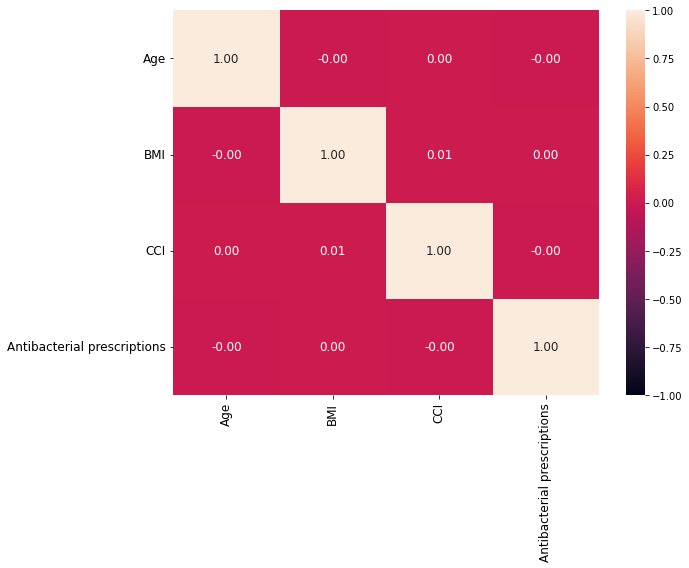

In [132]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_otmedia[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_otmedia/corr_otmedia.jpg')
plt.show()

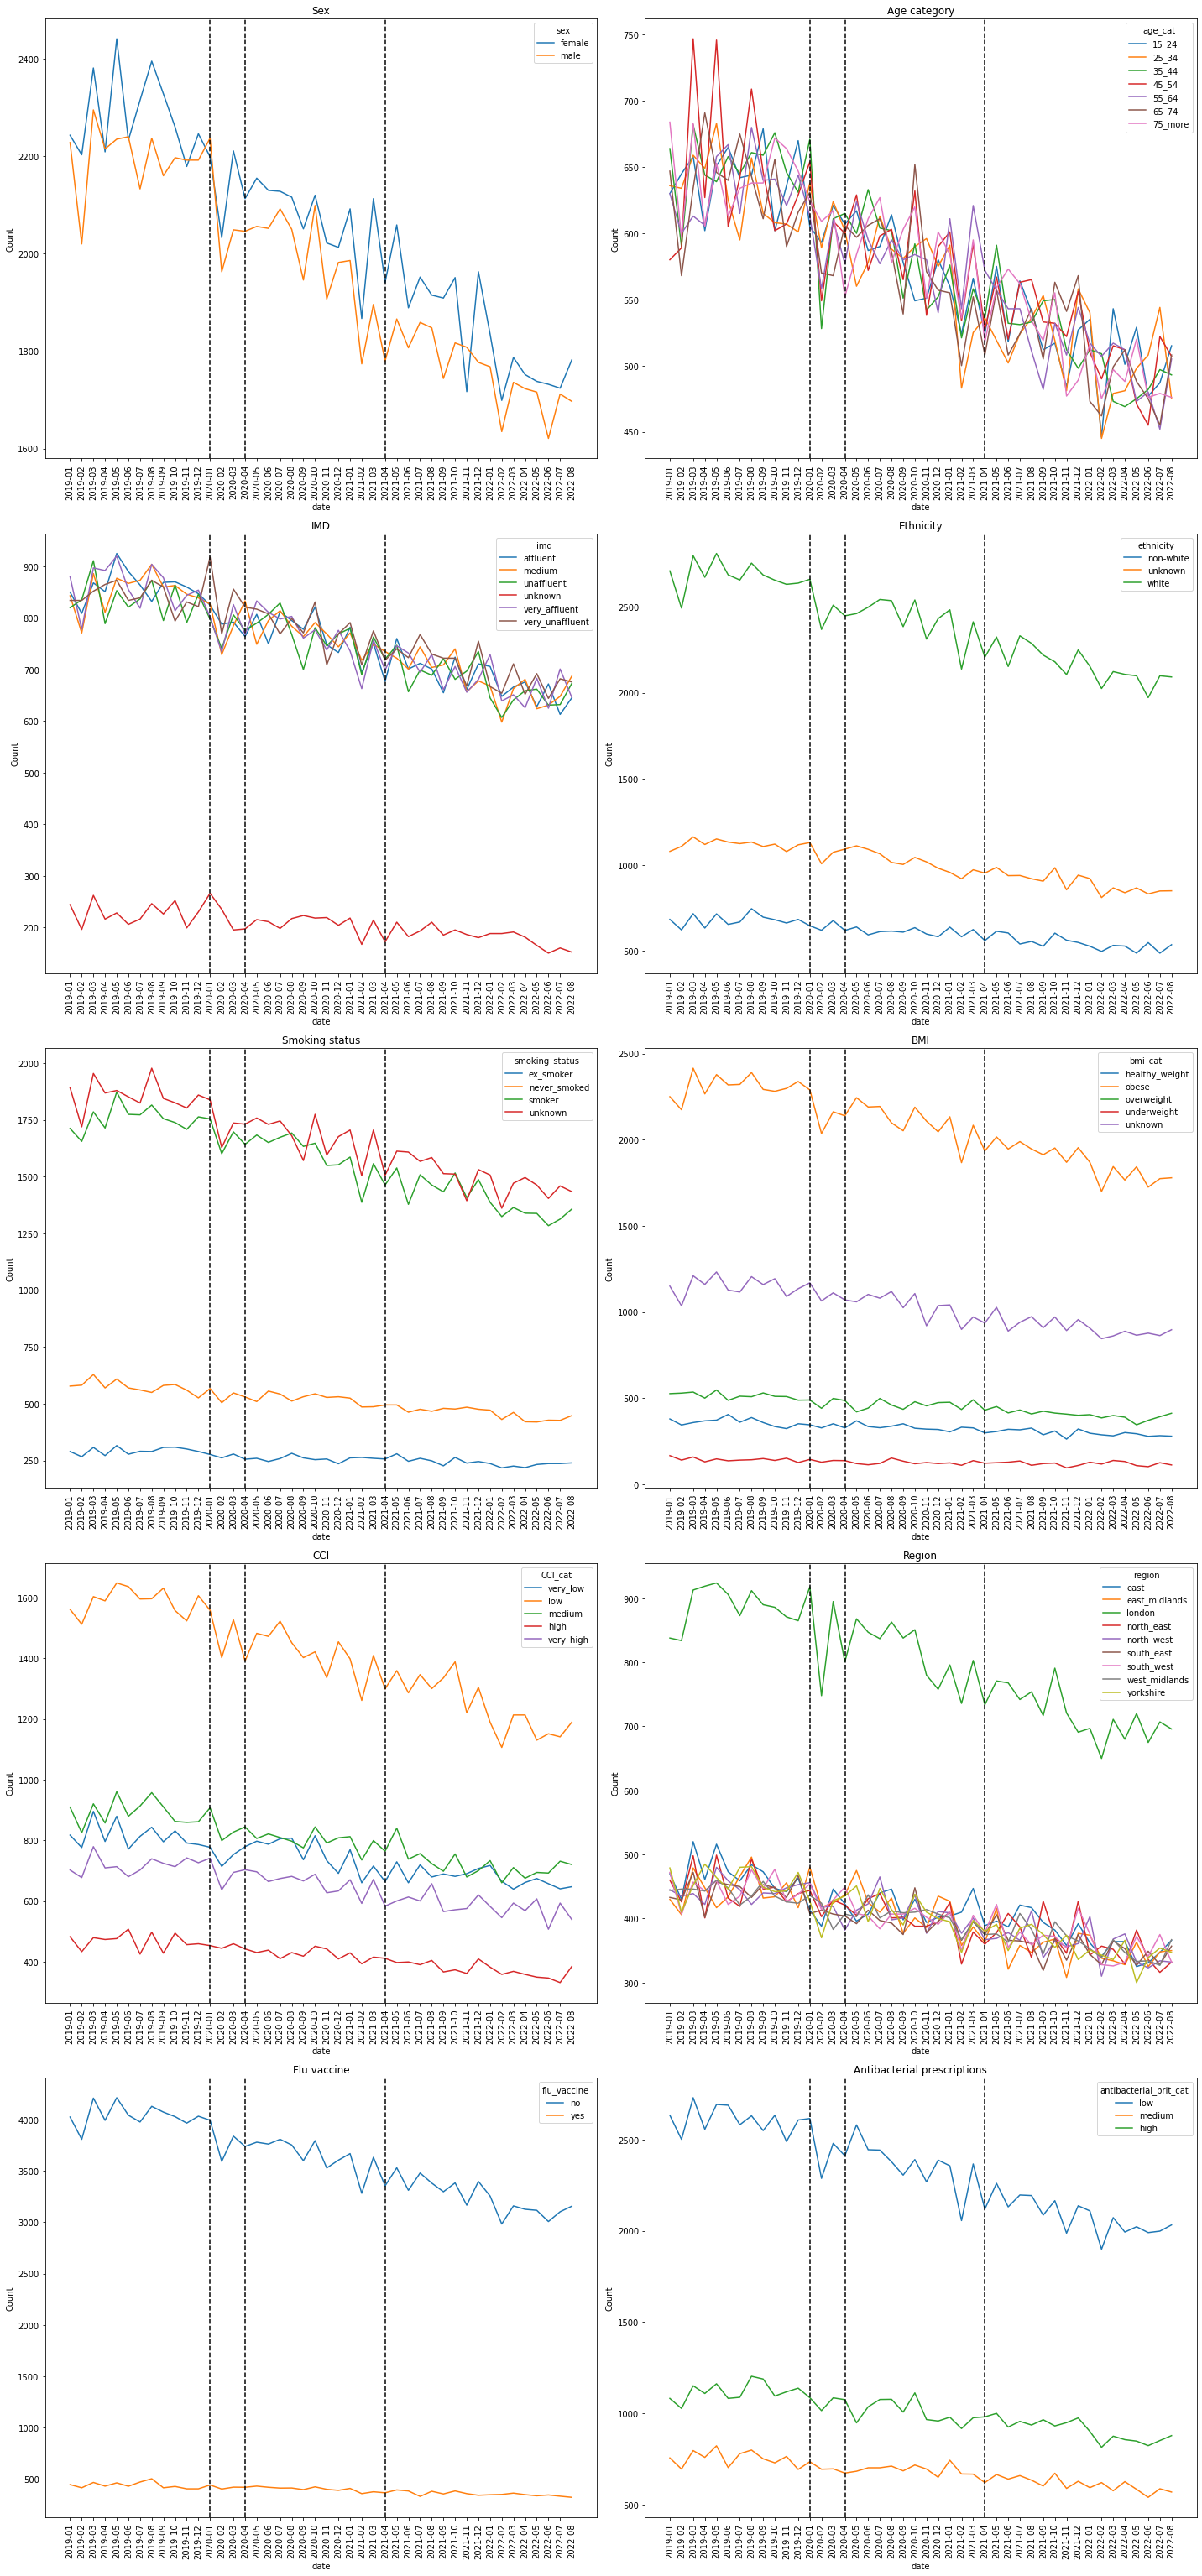

In [133]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_otmedia, 'sex', 'Sex', axes[0,0])
create_lineplot(data_otmedia, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_otmedia, 'imd', 'IMD', axes[1,0])
create_lineplot(data_otmedia, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_otmedia, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_otmedia, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_otmedia, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_otmedia, 'region', 'Region', axes[3,1])
create_lineplot(data_otmedia, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_otmedia, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of otmedia patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_otmedia/risk_factors_cat_otmedia.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of otmedia to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [134]:
data_otmedia = data_otmedia[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'otmedia_ab_date', 'ab_type_cat', 'incdt_otmedia_date', 'date', 'period',
                       'event_otmedia_admitted', 'duration_otmedia_admitted'
                        ]]

data_otmedia.shape

(176534, 18)

In [135]:
#incident and prevalent infection 
data_otmedia_incdt = data_otmedia[data_otmedia['incdt_otmedia_date'] == 0]
data_otmedia_prevl = data_otmedia[data_otmedia['incdt_otmedia_date'] == 1]
#switch variable otmedia_ab_date into a binary variable
data_otmedia_incdt[['otmedia_ab_date']] = data_otmedia_incdt[['otmedia_ab_date']].where(data_otmedia_incdt[['otmedia_ab_date']].isnull(), 1).fillna(0).astype(int)
data_otmedia_prevl[['otmedia_ab_date']] = data_otmedia_prevl[['otmedia_ab_date']].where(data_otmedia_prevl[['otmedia_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_otmedia_incdt_males = data_otmedia_incdt[data_otmedia_incdt['sex'] == 'male']
data_otmedia_incdt_females = data_otmedia_incdt[data_otmedia_incdt['sex'] == 'female']
data_otmedia_prevl_males = data_otmedia_prevl[data_otmedia_prevl['sex'] == 'male']
data_otmedia_prevl_females = data_otmedia_prevl[data_otmedia_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_otmedia_incdt_15_24 = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '15_24']
data_otmedia_incdt_25_34 = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '25_34']
data_otmedia_incdt_35_44 = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '35_44']
data_otmedia_incdt_45_54 = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '45_54']
data_otmedia_incdt_55_64 = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '55_64']
data_otmedia_incdt_65_74 = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '65_74']
data_otmedia_incdt_75_more = data_otmedia_incdt[data_otmedia_incdt['age_cat'] == '75_more']
data_otmedia_prevl_15_24 = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '15_24']
data_otmedia_prevl_25_34 = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '25_34']
data_otmedia_prevl_35_44 = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '35_44']
data_otmedia_prevl_45_54 = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '45_54']
data_otmedia_prevl_55_64 = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '55_64']
data_otmedia_prevl_65_74 = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '65_74']
data_otmedia_prevl_75_more = data_otmedia_prevl[data_otmedia_prevl['age_cat'] == '75_more']

data_otmedia_incdt_prepandemic = data_otmedia_incdt[data_otmedia_incdt['date'] <= '2019-12']
data_otmedia_incdt_during_pandemic = data_otmedia_incdt[(data_otmedia_incdt['date'] >= '2020-03') & (data_otmedia_incdt['date']<= '2021-03')]
data_otmedia_incdt_post_2nd_lockdown = data_otmedia_incdt[data_otmedia_incdt['date'] <= '2021-04']
data_otmedia_prevl_prepandemic = data_otmedia_prevl[data_otmedia_prevl['date'] <= '2019-12']
data_otmedia_prevl_during_pandemic = data_otmedia_prevl[(data_otmedia_prevl['date'] >= '2020-03') & (data_otmedia_prevl['date']<= '2021-03')]
data_otmedia_prevl_post_2nd_lockdown = data_otmedia_prevl[data_otmedia_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_otmedia_incdt_abtype_0 = data_otmedia_incdt[data_otmedia_incdt['ab_type_cat'] == data_otmedia['ab_type_cat'].unique()[0]]
# data_otmedia_incdt_abtype_1 = data_otmedia_incdt[data_otmedia_incdt['ab_type_cat'] == data_otmedia['ab_type_cat'].unique()[1]]
# data_otmedia_incdt_abtype_2 = data_otmedia_incdt[data_otmedia_incdt['ab_type_cat'] == data_otmedia['ab_type_cat'].unique()[2]]
# data_otmedia_incdt_abtype_3 = data_otmedia_incdt[data_otmedia_incdt['ab_type_cat'] == data_otmedia['ab_type_cat'].unique()[3]]
# data_otmedia_prevl_abtype_0 = data_otmedia_prevl[data_otmedia_prevl['ab_type_cat'] == data_otmedia['ab_type_cat'].unique()[0]]
# data_otmedia_prevl_abtype_1 = data_otmedia_prevl[data_otmedia_prevl['ab_type_cat'] == data_otmedia['ab_type_cat'].unique()[1]]
# data_otmedia_prevl_abtype_2 = data_otmedia_prevl[data_otmedia_prevl['ab_type_cat'] == data_otmedia['ab_type_cat'].unique()[2]]
# data_otmedia_prevl_abtype_3 = data_otmedia_prevl[data_otmedia_prevl['ab_type_cat'] == data_otmedia['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_otmedia_incdt_abs = data_otmedia_incdt[data_otmedia_incdt['otmedia_ab_date'] == 1]
# data_otmedia_prevl_abs = data_otmedia_prevl[data_otmedia_prevl['otmedia_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_otmedia_no_abs_incdt = data_otmedia[data_otmedia['otmedia_ab_date'].isnull()] #gp_cons_otmedia_ab
data_otmedia_no_abs_incdt = data_otmedia_no_abs_incdt[data_otmedia_no_abs_incdt['incdt_otmedia_date'] == 0]

# with antibiotics and incident hospital admission
data_otmedia_abs_incdt = data_otmedia[data_otmedia['otmedia_ab_date'].notnull()]
data_otmedia_abs_incdt = data_otmedia_abs_incdt[data_otmedia_abs_incdt['incdt_otmedia_date'] == 0]

# no antibiotics and prevalent hospital admission
data_otmedia_no_abs_prevl = data_otmedia[data_otmedia['otmedia_ab_date'].isnull()]
data_otmedia_no_abs_prevl = data_otmedia_no_abs_prevl[data_otmedia_no_abs_prevl['incdt_otmedia_date'] == 1]

# with antibiotics and prevalent hospital admission
data_otmedia_abs_prevl = data_otmedia[data_otmedia['otmedia_ab_date'].notnull()]
data_otmedia_abs_prevl = data_otmedia_abs_prevl[data_otmedia_abs_prevl['incdt_otmedia_date'] == 1]

print(f'shape of data_otmedia_incdt: {data_otmedia_incdt.shape}')
print(f'shape of data_otmedia_prevl: {data_otmedia_prevl.shape}')
print(f'shape of data_otmedia_no_abs_incdt: {data_otmedia_no_abs_incdt.shape}')
print(f'shape of data_otmedia_abs_incdt: {data_otmedia_abs_incdt.shape}')
print(f'shape of data_otmedia_no_abs_prevl: {data_otmedia_no_abs_prevl.shape}')
print(f'shape of data_otmedia_abs_prevl: {data_otmedia_abs_prevl.shape}')
print(f'\nvalue counts of data_otmedia_no_abs_incdt: \n{data_otmedia_no_abs_incdt.event_otmedia_admitted.value_counts()}')
print(f'value counts of data_otmedia_abs_incdt: \n{data_otmedia_abs_incdt.event_otmedia_admitted.value_counts()}')
print(f'value counts of data_otmedia_no_abs_prevl: \n{data_otmedia_no_abs_prevl.event_otmedia_admitted.value_counts()}')
print(f'value counts of data_otmedia_abs_prevl: \n{data_otmedia_abs_prevl.event_otmedia_admitted.value_counts()}')

shape of data_otmedia_incdt: (158938, 18)
shape of data_otmedia_prevl: (17596, 18)
shape of data_otmedia_no_abs_incdt: (143106, 18)
shape of data_otmedia_abs_incdt: (15832, 18)
shape of data_otmedia_no_abs_prevl: (15801, 18)
shape of data_otmedia_abs_prevl: (1795, 18)

value counts of data_otmedia_no_abs_incdt: 
0.0    142065
1.0      1041
Name: event_otmedia_admitted, dtype: int64
value counts of data_otmedia_abs_incdt: 
0.0    15711
1.0      121
Name: event_otmedia_admitted, dtype: int64
value counts of data_otmedia_no_abs_prevl: 
0.0    15659
1.0      142
Name: event_otmedia_admitted, dtype: int64
value counts of data_otmedia_abs_prevl: 
0.0    1785
1.0      10
Name: event_otmedia_admitted, dtype: int64


In [136]:
#store data for plotting hosp admission counts and percentages
%store data_otmedia
# save data
data_otmedia.to_csv('../output/hospitalisation_prediction_otmedia/data_otmedia.csv')

Stored 'data_otmedia' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident otmedia with no antibiotics

<lifelines.CoxPHFitter: fitted with 107329 total observations, 106550 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 107329
number of events observed = 779
   partial log-likelihood = -9010.53
         time fit was run = 2022-11-24 01:43:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.92       0.10            -0.28             0.11                 0.75                 1.12
CCI_cat[T.medium]               -0.05       0.96       0.11            -0.27             0.18                 0.77                 1.19
CCI_cat[T.high]                 -0.01       0.99       0.13            -0.27             0.25                 0.76                 1.28
CCI_cat[T.very_high]            -0.23       0.80       0.13            -0.47             0.02                 0.62                 1.02
age_cat[T.25_34]                 0.19       1.21       0.14            -0.08             0.46                 0.93                 1.58
age_cat[T.35_44]                 0.21       1.24       0.13            -0.05             0.48                 0.95                 1.61
age_cat[T.45_54]                 0.06       1.06       0.14            -0.21             0.33                 0.81                 1.40
age_cat[T.55_64]                 0.04       1.04       0.14            -0.23             0.32                 0.79                 1.37
age_cat[T.65_74]                 0.12       1.13       0.14            -0.15             0.39                 0.86                 1.48
age_cat[T.75_more]               0.11       1.12       0.14            -0.16             0.38                 0.85                 1.47
antibacterial_brit               0.02       1.02       0.02            -0.03             0.07                 0.97                 1.08
bmi_cat[T.obese]                 0.13       1.14       0.14            -0.15             0.41                 0.86                 1.50
bmi_cat[T.overweight]            0.11       1.12       0.17            -0.23             0.45                 0.80                 1.56
bmi_cat[T.underweight]           0.21       1.23       0.23            -0.25             0.67                 0.78                 1.95
bmi_cat[T.unknown]               0.17       1.18       0.15            -0.13             0.46                 0.88                 1.59
ethnicity[T.unknown]             0.02       1.02       0.12            -0.20             0.25                 0.81                 1.29
ethnicity[T.white]              -0.01       0.99       0.10            -0.21             0.20                 0.81                 1.22
flu_vaccine[T.yes]               0.06       1.07       0.12            -0.16             0.29                 0.85                 1.34
imd[T.medium]                    0.04       1.04       0.12            -0.19             0.27                 0.83                 1.31
imd[T.unaffluent]               -0.03       0.97       0.12            -0.27             0.20                 0.77                 1.22
imd[T.unknown]                  -0.04       0.96       0.18            -0.40             0.33                 0.67                 1.38
imd[T.very_affluent]             0.06       1.06       0.12            -0.17             0.28                 0.84                 1.33
imd[T.very_unaffluent]           0.08       1.09       0.12            -0.14             0.31                 0.87                 1.36
region[T.east_midlands]         -0.05       0.95       0.16            -0.37             0.28                 0.69                 1.32
region[T.london]                 0.08       1.08       0.14

12768


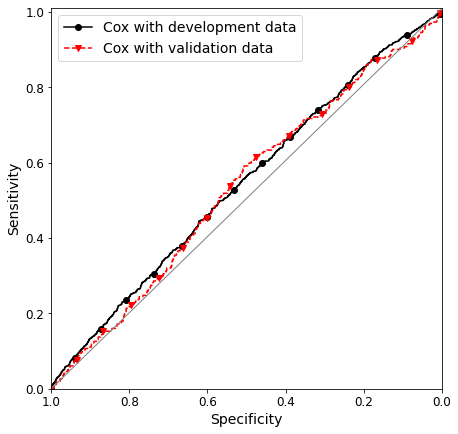

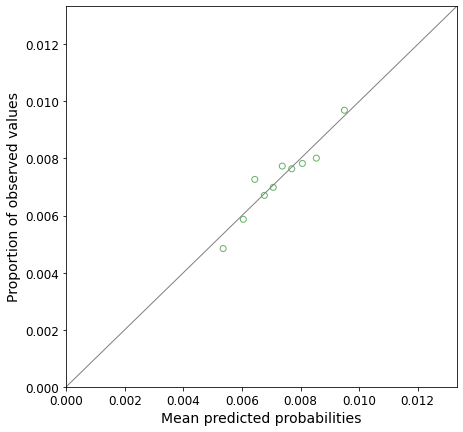

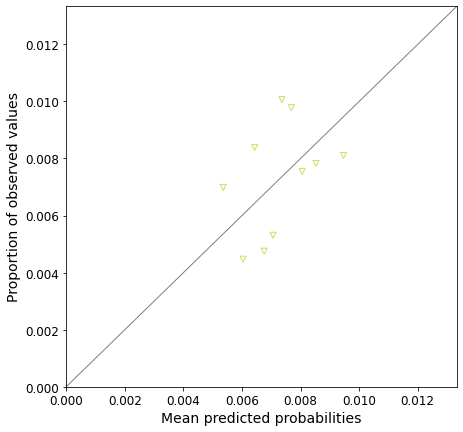

In [137]:
#data prep
data, data_otmedia_no_abs_incdt_enc = cox_data_prep(data_otmedia_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary table
make_summary_table('otmedia', 'no_abs_incdt', data_otmedia_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('otmedia', 'no_abs_incdt', data_otmedia_no_abs_incdt)

try:
    #build cox model 
    cph_otmedia_no_abs_incdt, data_otmedia_no_abs_incdt_train, data_otmedia_no_abs_incdt_test = cox_model_build('otmedia', 'no_abs_incdt', data_otmedia_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_otmedia_no_abs_incdt, '../output/hospitalisation_prediction_otmedia/', 'betas_cph_otmedia_no_abs_incdt.csv', data_otmedia_no_abs_incdt_enc, data_otmedia_no_abs_incdt, 'sum_betas_cph_otmedia_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_otmedia_no_abs_incdt, 'event_otmedia_admitted', data_otmedia_no_abs_incdt_train, data_otmedia_no_abs_incdt_test, '../output/hospitalisation_prediction_otmedia', 'roc_cph_otmedia_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_otmedia_no_abs_incdt, data_otmedia_no_abs_incdt_train, 'event_otmedia_admitted', data_otmedia_no_abs_incdt_test, '../output/hospitalisation_prediction_otmedia/', 'calibration_cph_otmedia_no_abs_incdt_train.jpg', 'calibration_cph_otmedia_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_no_abs_incdt, 'otmedia', 'no_abs_incdt', data_otmedia_no_abs_incdt_train, data_otmedia_no_abs_incdt_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident otmedia with antibiotics

<lifelines.CoxPHFitter: fitted with 11874 total observations, 11783 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 11874
number of events observed = 91
   partial log-likelihood = -826.36
         time fit was run = 2022-11-24 01:43:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.10       0.91       0.30            -0.68             0.48                 0.51                 1.62
CCI_cat[T.medium]               -0.54       0.59       0.37            -1.27             0.20                 0.28                 1.22
CCI_cat[T.high]                 -0.06       0.95       0.40            -0.83             0.72                 0.44                 2.06
CCI_cat[T.very_high]             0.11       1.12       0.33            -0.54             0.76                 0.58                 2.13
age_cat[T.25_34]                -0.23       0.79       0.34            -0.90             0.44                 0.41                 1.55
age_cat[T.35_44]                -0.42       0.66       0.36            -1.12             0.28                 0.33                 1.32
age_cat[T.45_54]                -0.28       0.76       0.35            -0.97             0.40                 0.38                 1.50
age_cat[T.55_64]                -0.54       0.58       0.38            -1.27             0.20                 0.28                 1.22
age_cat[T.65_74]                -0.40       0.67       0.37            -1.12             0.32                 0.33                 1.37
age_cat[T.75_more]              -1.17       0.31       0.47            -2.09            -0.26                 0.12                 0.77
antibacterial_brit               0.10       1.11       0.07            -0.04             0.24                 0.96                 1.27
bmi_cat[T.obese]                 0.48       1.62       0.47            -0.44             1.40                 0.64                 4.05
bmi_cat[T.overweight]            0.41       1.50       0.54            -0.65             1.47                 0.52                 4.34
bmi_cat[T.underweight]           1.15       3.14       0.61            -0.05             2.34                 0.95                10.36
bmi_cat[T.unknown]              -0.00       1.00       0.51            -1.01             1.01                 0.37                 2.73
ethnicity[T.unknown]            -0.35       0.70       0.35            -1.04             0.34                 0.35                 1.40
ethnicity[T.white]              -0.02       0.98       0.29            -0.59             0.55                 0.55                 1.73
flu_vaccine[T.yes]               0.38       1.46       0.31            -0.23             0.98                 0.79                 2.68
imd[T.medium]                   -0.01       0.99       0.33            -0.64             0.63                 0.53                 1.88
imd[T.unaffluent]               -0.11       0.90       0.33            -0.75             0.54                 0.47                 1.72
imd[T.unknown]                  -1.67       0.19       1.03            -3.68             0.34                 0.03                 1.41
imd[T.very_affluent]            -0.14       0.87       0.33            -0.80             0.51                 0.45                 1.67
imd[T.very_unaffluent]          -0.19       0.82       0.33            -0.85             0.46                 0.43                 1.59
region[T.east_midlands]          0.74       2.09       0.49            -0.23             1.71                 0.79                 5.52
region[T.london]                 0.81       2.24       0.45     

12784


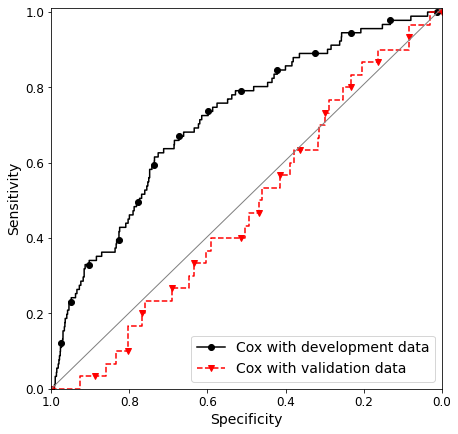

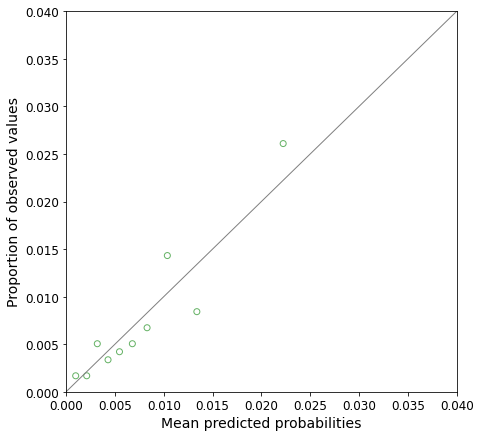

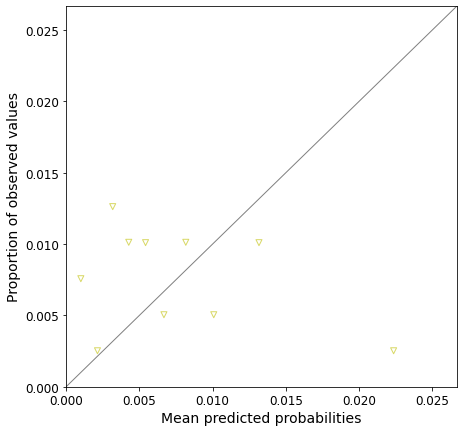

In [138]:
#data prep
data, data_otmedia_abs_incdt_enc = cox_data_prep(data_otmedia_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary table
make_summary_table('otmedia', 'abs_incdt', data_otmedia_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('otmedia', 'abs_incdt', data_otmedia_abs_incdt)

try:
    #build cox model 
    cph_otmedia_abs_incdt, data_otmedia_abs_incdt_train, data_otmedia_abs_incdt_test = cox_model_build('otmedia', 'abs_incdt', data_otmedia_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_otmedia_abs_incdt, '../output/hospitalisation_prediction_otmedia/', 'betas_cph_otmedia_abs_incdt.csv', data_otmedia_abs_incdt_enc, data_otmedia_abs_incdt, 'sum_betas_cph_otmedia_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_otmedia_abs_incdt, 'event_otmedia_admitted', data_otmedia_abs_incdt_train, data_otmedia_abs_incdt_test, '../output/hospitalisation_prediction_otmedia', 'roc_cph_otmedia_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_otmedia_abs_incdt, data_otmedia_abs_incdt_train, 'event_otmedia_admitted', data_otmedia_abs_incdt_test, '../output/hospitalisation_prediction_otmedia/', 'calibration_cph_otmedia_abs_incdt_train.jpg', 'calibration_cph_otmedia_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_abs_incdt, 'otmedia', 'abs_incdt', data_otmedia_abs_incdt_train, data_otmedia_abs_incdt_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent otmedia with no antibiotics

<lifelines.CoxPHFitter: fitted with 11850 total observations, 11745 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 11850
number of events observed = 105
   partial log-likelihood = -967.00
         time fit was run = 2022-11-24 01:43:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.79       0.29            -0.80             0.32                 0.45                 1.38
CCI_cat[T.medium]                0.10       1.10       0.30            -0.49             0.68                 0.61                 1.98
CCI_cat[T.high]                  0.19       1.21       0.35            -0.49             0.87                 0.61                 2.38
CCI_cat[T.very_high]            -0.11       0.89       0.33            -0.77             0.54                 0.47                 1.71
age_cat[T.25_34]                -0.34       0.71       0.41            -1.15             0.47                 0.32                 1.61
age_cat[T.35_44]                 0.02       1.02       0.38            -0.72             0.76                 0.48                 2.14
age_cat[T.45_54]                 0.12       1.12       0.37            -0.60             0.84                 0.55                 2.31
age_cat[T.55_64]                 0.12       1.12       0.37            -0.60             0.84                 0.55                 2.31
age_cat[T.65_74]                 0.28       1.32       0.35            -0.42             0.97                 0.66                 2.64
age_cat[T.75_more]               0.14       1.15       0.37            -0.58             0.86                 0.56                 2.35
antibacterial_brit               0.03       1.03       0.07            -0.11             0.16                 0.90                 1.17
bmi_cat[T.obese]                 0.12       1.12       0.40            -0.67             0.91                 0.51                 2.48
bmi_cat[T.overweight]            0.61       1.84       0.45            -0.27             1.48                 0.77                 4.40
bmi_cat[T.underweight]           0.39       1.48       0.63            -0.84             1.62                 0.43                 5.08
bmi_cat[T.unknown]               0.10       1.10       0.43            -0.74             0.94                 0.48                 2.55
ethnicity[T.unknown]            -0.41       0.67       0.32            -1.04             0.23                 0.35                 1.25
ethnicity[T.white]              -0.14       0.87       0.27            -0.66             0.38                 0.51                 1.47
flu_vaccine[T.yes]              -0.03       0.97       0.33            -0.68             0.62                 0.51                 1.87
imd[T.medium]                   -0.16       0.86       0.30            -0.75             0.43                 0.47                 1.54
imd[T.unaffluent]               -0.71       0.49       0.35            -1.40            -0.02                 0.25                 0.98
imd[T.unknown]                  -0.73       0.48       0.61            -1.93             0.47                 0.15                 1.60
imd[T.very_affluent]             0.16       1.18       0.28            -0.38             0.70                 0.69                 2.02
imd[T.very_unaffluent]          -0.32       0.73       0.31            -0.93             0.30                 0.39                 1.35
region[T.east_midlands]         -0.42       0.65       0.53            -1.46             0.61                 0.23                 1.84
region[T.london]                -0.03       0.97       0.41    

12775


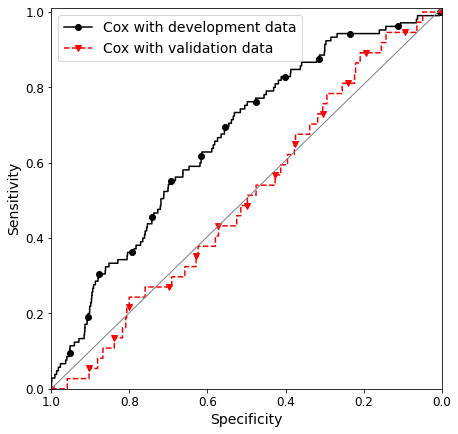

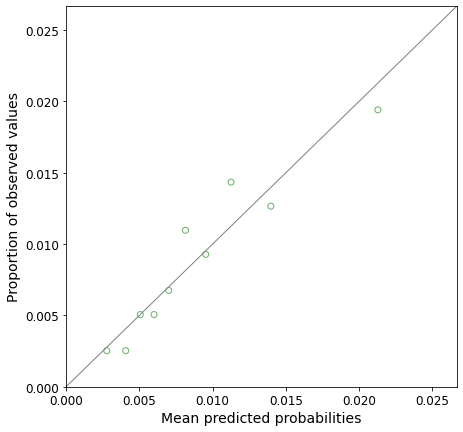

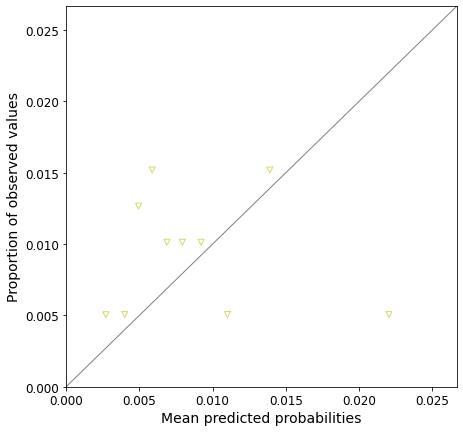

In [139]:
#data prep
data, data_otmedia_no_abs_prevl_enc = cox_data_prep(data_otmedia_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary table
make_summary_table('otmedia', 'no_abs_prevl', data_otmedia_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('otmedia', 'no_abs_prevl', data_otmedia_no_abs_prevl)

try:
    #build cox model 
    cph_otmedia_no_abs_prevl, data_otmedia_no_abs_prevl_train, data_otmedia_no_abs_prevl_test = cox_model_build('otmedia', 'no_abs_prevl', data_otmedia_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_otmedia_no_abs_prevl, '../output/hospitalisation_prediction_otmedia/', 'betas_cph_otmedia_no_abs_prevl.csv', data_otmedia_no_abs_prevl_enc, data_otmedia_no_abs_prevl, 'sum_betas_cph_otmedia_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_otmedia_no_abs_prevl, 'event_otmedia_admitted', data_otmedia_no_abs_prevl_train, data_otmedia_no_abs_prevl_test, '../output/hospitalisation_prediction_otmedia', 'roc_cph_otmedia_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_otmedia_no_abs_prevl, data_otmedia_no_abs_prevl_train, 'event_otmedia_admitted', data_otmedia_no_abs_prevl_test, '../output/hospitalisation_prediction_otmedia/', 'calibration_cph_otmedia_no_abs_prevl_train.jpg', 'calibration_cph_otmedia_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_no_abs_prevl, 'otmedia', 'no_abs_prevl', data_otmedia_no_abs_prevl_train, data_otmedia_no_abs_prevl_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent otmedia with antibiotics

<lifelines.CoxPHFitter: fitted with 1346 total observations, 1339 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1346
number of events observed = 7
   partial log-likelihood = -31.91
         time fit was run = 2022-11-24 01:43:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.17       0.31       1.17            -3.46             1.12                 0.03                 3.06
CCI_cat[T.medium]               -0.97       0.38       1.33            -3.58             1.63                 0.03                 5.10
CCI_cat[T.high]                -18.90       0.00   11804.07        -23154.46         23116.66                 0.00                  inf
CCI_cat[T.very_high]            -1.34       0.26       1.38            -4.05             1.36                 0.02                 3.89
age_cat[T.25_34]               -18.42       0.00    8713.63        -17096.82         17059.99                 0.00                  inf
age_cat[T.35_44]                -0.24       0.79       1.44            -3.07             2.59                 0.05                13.31
age_cat[T.45_54]                -0.06       0.94       1.43            -2.86             2.73                 0.06                15.37
age_cat[T.55_64]               -19.34       0.00   10812.54        -21211.53         21172.85                 0.00                  inf
age_cat[T.65_74]                 0.46       1.59       1.37            -2.22             3.14                 0.11                23.19
age_cat[T.75_more]             -18.87       0.00    8727.16        -17123.78         17086.05                 0.00                  inf
antibacterial_brit              -0.13       0.88       0.32            -0.76             0.50                 0.47                 1.65
bmi_cat[T.obese]                18.80   1.46e+08   14896.08        -29176.98         29214.57                 0.00                  inf
bmi_cat[T.overweight]           20.29   6.47e+08   14896.08        -29175.49         29216.06                 0.00                  inf
bmi_cat[T.underweight]           0.31       1.37   24657.37        -48327.25         48327.87                 0.00                  inf
bmi_cat[T.unknown]               0.25       1.28   16685.11        -32701.98         32702.47                 0.00                  inf
ethnicity[T.unknown]            18.51   1.09e+08    8205.99        -16064.94         16101.96                 0.00                  inf
ethnicity[T.white]              18.11   7.35e+07    8205.99        -16065.34         16101.57                 0.00                  inf
flu_vaccine[T.yes]               0.78       2.17       1.25            -1.67             3.22                 0.19                25.00
imd[T.medium]                   -1.13       0.32       1.33            -3.74             1.48                 0.02                 4.40
imd[T.unaffluent]                0.01       1.01       1.41            -2.77             2.78                 0.06                16.11
imd[T.unknown]                 -17.86       0.00   14025.51        -27507.36         27471.64                 0.00                  inf
imd[T.very_affluent]           -18.31       0.00    7318.78        -14362.85         14326.24                 0.00                  inf
imd[T.very_unaffluent]           0.74       2.09       1.17            -1.55             3.03                 0.21                20.69
region[T.east_midlands]         18.72   1.36e+08    8984.64        -17590.85         17628.30                 0.00                  inf
region[T.london]                19.02   1.82e+08    8984.64        -1

13043


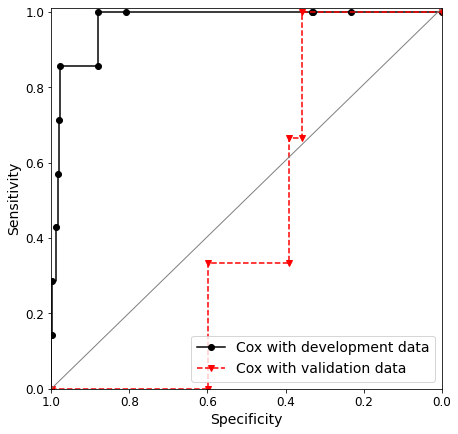

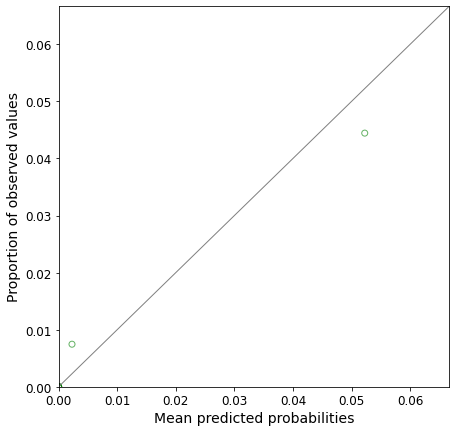

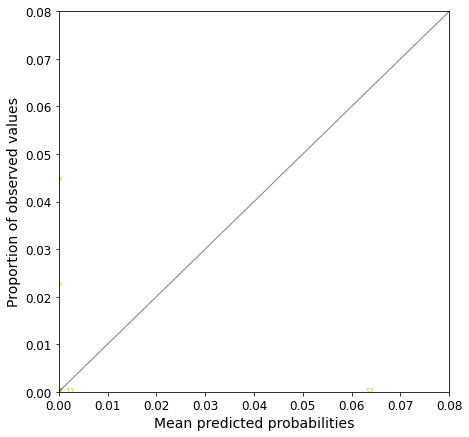

In [140]:
#data prep
data, data_otmedia_abs_prevl_enc = cox_data_prep(data_otmedia_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary table
make_summary_table('otmedia', 'abs_prevl', data_otmedia_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('otmedia', 'abs_prevl', data_otmedia_abs_prevl)

try:
    #build cox model 
    cph_otmedia_abs_prevl, data_otmedia_abs_prevl_train, data_otmedia_abs_prevl_test = cox_model_build('otmedia', 'abs_prevl', data_otmedia_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_otmedia_abs_prevl, '../output/hospitalisation_prediction_otmedia/', 'betas_cph_otmedia_abs_prevl.csv', data_otmedia_abs_prevl_enc, data_otmedia_abs_prevl, 'sum_betas_cph_otmedia_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_otmedia_abs_prevl, 'event_otmedia_admitted', data_otmedia_abs_prevl_train, data_otmedia_abs_prevl_test, '../output/hospitalisation_prediction_otmedia', 'roc_cph_otmedia_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_otmedia_abs_prevl, data_otmedia_abs_prevl_train, 'event_otmedia_admitted', data_otmedia_abs_prevl_test, '../output/hospitalisation_prediction_otmedia/', 'calibration_cph_otmedia_abs_prevl_train.jpg', 'calibration_cph_otmedia_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_abs_prevl, 'otmedia', 'abs_prevl', data_otmedia_abs_prevl_train, data_otmedia_abs_prevl_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident otmedia

In [141]:
#data prep
data, data_otmedia_incdt_enc = cox_data_prep(data_otmedia_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary tables from preped data
make_summary_table('otmedia', 'incdt', data_otmedia_incdt_enc)
make_summary_table_hosped('otmedia', 'incdt', data_otmedia_incdt)

try:
    cph_otmedia_incdt, data_otmedia_incdt_train, data_otmedia_incdt_test = cox_model_abs_build('otmedia', 'incdt', data_otmedia_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt, 'otmedia', 'incdt', data_otmedia_incdt_train, data_otmedia_incdt_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 119203 total observations, 118321 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 119203
number of events observed = 882
   partial log-likelihood = -10287.13
         time fit was run = 2022-11-24 01:43:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       0.09            -0.27             0.10                 0.77                 1.11
CCI_cat[T.medium]               -0.18       0.83       0.11            -0.39             0.03                 0.67                 1.03
CCI_cat[T.high]                 -0.03       0.97       0.13            -0.27             0.22                 0.76                 1.25
CCI_cat[T.very_high]            -0.18       0.84       0.11            -0.40             0.05                 0.67                 1.05
age_cat[T.25_34]                 0.13       1.13       0.12            -0.11             0.36                 0.89                 1.44
age_cat[T.35_44]                 0.07       1.07       0.12            -0.17             0.31                 0.84                 1.36
age_cat[T.45_54]                -0.12       0.89       0.13            -0.37             0.13                 0.69                 1.14
age_cat[T.55_64]                -0.19       0.83       0.13            -0.44             0.07                 0.64                 1.07
age_cat[T.65_74]                 0.05       1.05       0.12            -0.19             0.29                 0.83                 1.34
age_cat[T.75_more]              -0.11       0.89       0.13            -0.37             0.14                 0.69                 1.15
antibacterial_brit               0.03       1.03       0.02            -0.02             0.08                 0.98                 1.08
bmi_cat[T.obese]                 0.07       1.08       0.13            -0.18             0.33                 0.83                 1.39
bmi_cat[T.overweight]            0.12       1.13       0.16            -0.19             0.42                 0.83                 1.53
bmi_cat[T.underweight]           0.25       1.28       0.21            -0.16             0.66                 0.85                 1.94
bmi_cat[T.unknown]               0.02       1.02       0.14            -0.26             0.29                 0.77                 1.34
ethnicity[T.unknown]             0.08       1.08       0.11            -0.14             0.29                 0.87                 1.34
ethnicity[T.white]               0.03       1.03       0.10            -0.17             0.22                 0.85                 1.24
flu_vaccine[T.yes]               0.14       1.15       0.11            -0.06             0.35                 0.94                 1.42
imd[T.medium]                    0.06       1.06       0.11            -0.15             0.27                 0.86                 1.31
imd[T.unaffluent]               -0.06       0.94       0.11            -0.28             0.15                 0.76                 1.17
imd[T.unknown]                  -0.45       0.64       0.20            -0.85            -0.06                 0.43                 0.94
imd[T.very_affluent]            -0.02       0.98       0.11            -0.23             0.20                 0.80                 1.22
imd[T.very_unaffluent]           0.01       1.01       0.11            -0.20             0.22                 0.82                 1.25
otmedia_ab_date                  0.16       1.17       0.11            -0.05             0.36                 0.95                 1.44
region[T.east_midlands]         -0.10       0.90       0.1

13059


### 5-6- hospital admission related to prevalent otmedia

In [142]:
#data prep
data, data_otmedia_prevl_enc = cox_data_prep(data_otmedia_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

#make summary tables from preped data
make_summary_table('otmedia', 'prevl', data_otmedia_prevl_enc)
make_summary_table_hosped('otmedia', 'prevl', data_otmedia_prevl)

try:
    cph_otmedia_prevl, data_otmedia_prevl_train, data_otmedia_prevl_test = cox_model_abs_build('otmedia', 'prevl', data_otmedia_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl, 'otmedia', 'prevl', data_otmedia_prevl_train, data_otmedia_prevl_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13197 total observations, 13082 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 13197
number of events observed = 115
   partial log-likelihood = -1063.52
         time fit was run = 2022-11-24 01:43:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.48       0.62       0.27            -1.00             0.04                 0.37                 1.04
CCI_cat[T.medium]               -0.09       0.92       0.28            -0.63             0.45                 0.53                 1.57
CCI_cat[T.high]                  0.05       1.05       0.32            -0.58             0.68                 0.56                 1.98
CCI_cat[T.very_high]            -0.32       0.73       0.31            -0.93             0.29                 0.39                 1.33
age_cat[T.25_34]                -0.36       0.70       0.38            -1.10             0.38                 0.33                 1.47
age_cat[T.35_44]                -0.17       0.84       0.36            -0.88             0.54                 0.41                 1.71
age_cat[T.45_54]                 0.04       1.04       0.34            -0.62             0.71                 0.54                 2.03
age_cat[T.55_64]                -0.34       0.71       0.38            -1.08             0.40                 0.34                 1.49
age_cat[T.65_74]                 0.17       1.18       0.33            -0.47             0.81                 0.62                 2.25
age_cat[T.75_more]               0.21       1.24       0.33            -0.43             0.86                 0.65                 2.35
antibacterial_brit               0.08       1.08       0.06            -0.05             0.20                 0.95                 1.22
bmi_cat[T.obese]                 0.55       1.73       0.47            -0.37             1.46                 0.69                 4.31
bmi_cat[T.overweight]            0.91       2.49       0.50            -0.08             1.90                 0.93                 6.67
bmi_cat[T.underweight]           0.86       2.36       0.63            -0.38             2.10                 0.68                 8.17
bmi_cat[T.unknown]               0.55       1.73       0.48            -0.40             1.50                 0.67                 4.48
ethnicity[T.unknown]            -0.57       0.57       0.33            -1.20             0.07                 0.30                 1.07
ethnicity[T.white]              -0.02       0.98       0.26            -0.52             0.49                 0.59                 1.62
flu_vaccine[T.yes]              -0.27       0.77       0.35            -0.95             0.42                 0.39                 1.52
imd[T.medium]                    0.28       1.33       0.28            -0.26             0.83                 0.77                 2.29
imd[T.unaffluent]               -0.41       0.66       0.33            -1.06             0.24                 0.35                 1.28
imd[T.unknown]                  -0.68       0.51       0.61            -1.88             0.53                 0.15                 1.69
imd[T.very_affluent]             0.22       1.25       0.28            -0.34             0.78                 0.71                 2.18
imd[T.very_unaffluent]          -0.24       0.79       0.32            -0.86             0.39                 0.42                 1.48
otmedia_ab_date                 -0.94       0.39       0.46            -1.84            -0.04                 0.16                 0.96
region[T.east_midlands]          0.01       1.01       0.47   

13046


### 5-7- hospital admission related to incident otmedia with prescribed antibiotics categories

In [143]:
#data prep
data, data_otmedia_incdt_abs_enc = cox_data_prep(data_otmedia_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_abs, data_otmedia_incdt_abs_train, data_otmedia_incdt_abs_test = cox_model_ab_type_build('otmedia', 'incdt_ab_type', data_otmedia_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_abs, 'otmedia', 'incdt_abs', data_otmedia_incdt_abs_train, data_otmedia_incdt_abs_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 119203 total observations, 118321 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 119203
number of events observed = 882
   partial log-likelihood = -10285.73
         time fit was run = 2022-11-24 01:43:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       0.09            -0.27             0.10                 0.77                 1.11
CCI_cat[T.medium]               -0.18       0.83       0.11            -0.39             0.03                 0.67                 1.03
CCI_cat[T.high]                 -0.03       0.97       0.13            -0.27             0.22                 0.76                 1.24
CCI_cat[T.very_high]            -0.18       0.84       0.11            -0.41             0.04                 0.67                 1.05
ab_type_cat[T.Doxycycline]      -1.14       0.32       1.05            -3.20             0.91                 0.04                 2.49
ab_type_cat[T.no]               -0.66       0.51       0.32            -1.29            -0.04                 0.28                 0.96
ab_type_cat[T.other]            -0.54       0.58       0.33            -1.19             0.11                 0.30                 1.12
age_cat[T.25_34]                 0.13       1.13       0.12            -0.11             0.36                 0.89                 1.44
age_cat[T.35_44]                 0.07       1.07       0.12            -0.17             0.31                 0.84                 1.36
age_cat[T.45_54]                -0.12       0.89       0.13            -0.37             0.13                 0.69                 1.14
age_cat[T.55_64]                -0.19       0.83       0.13            -0.44             0.07                 0.64                 1.07
age_cat[T.65_74]                 0.05       1.05       0.12            -0.19             0.29                 0.83                 1.34
age_cat[T.75_more]              -0.11       0.89       0.13            -0.37             0.14                 0.69                 1.15
antibacterial_brit               0.03       1.03       0.02            -0.02             0.08                 0.98                 1.08
bmi_cat[T.obese]                 0.07       1.08       0.13            -0.18             0.33                 0.83                 1.39
bmi_cat[T.overweight]            0.12       1.13       0.16            -0.18             0.43                 0.83                 1.53
bmi_cat[T.underweight]           0.25       1.28       0.21            -0.16             0.66                 0.85                 1.94
bmi_cat[T.unknown]               0.02       1.02       0.14            -0.26             0.29                 0.77                 1.33
ethnicity[T.unknown]             0.08       1.08       0.11            -0.14             0.29                 0.87                 1.34
ethnicity[T.white]               0.03       1.03       0.10            -0.17             0.22                 0.85                 1.24
flu_vaccine[T.yes]               0.14       1.16       0.11            -0.06             0.35                 0.94                 1.42
imd[T.medium]                    0.06       1.06       0.11            -0.15             0.27                 0.86                 1.31
imd[T.unaffluent]               -0.06       0.94       0.11            -0.28             0.15                 0.76                 1.17
imd[T.unknown]                  -0.45       0.64       0.20            -0.85            -0.06                 0.43                 0.94
imd[T.very_affluent]            -0.02       0.98       0.1

13626


### 5-8- hospital admission related to prevalent otmedia with prescribed antibiotics categories

In [144]:
#data prep
data, data_otmedia_prevl_abs_enc = cox_data_prep(data_otmedia_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_abs, data_otmedia_prevl_abs_train, data_otmedia_prevl_abs_test = cox_model_ab_type_build('otmedia', 'prevl_ab_type', data_otmedia_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_abs, 'otmedia', 'prevl_abs', data_otmedia_prevl_abs_train, data_otmedia_prevl_abs_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13197 total observations, 13082 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 13197
number of events observed = 115
   partial log-likelihood = -1063.08
         time fit was run = 2022-11-24 01:43:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.48       0.62       0.27            -1.00             0.04                 0.37                 1.04
CCI_cat[T.medium]               -0.09       0.92       0.28            -0.63             0.45                 0.53                 1.57
CCI_cat[T.high]                  0.05       1.05       0.32            -0.58             0.68                 0.56                 1.98
CCI_cat[T.very_high]            -0.32       0.73       0.31            -0.93             0.29                 0.39                 1.33
ab_type_cat[T.Doxycycline]       0.17       1.19    3365.10         -6595.31          6595.65                 0.00                  inf
ab_type_cat[T.no]               14.78   2.61e+06    1799.33         -3511.85          3541.40                 0.00                  inf
ab_type_cat[T.other]            13.92   1.11e+06    1799.33         -3512.70          3540.55                 0.00                  inf
age_cat[T.25_34]                -0.35       0.70       0.38            -1.09             0.39                 0.33                 1.47
age_cat[T.35_44]                -0.17       0.84       0.36            -0.88             0.54                 0.41                 1.71
age_cat[T.45_54]                 0.04       1.04       0.34            -0.62             0.71                 0.54                 2.03
age_cat[T.55_64]                -0.34       0.71       0.38            -1.08             0.40                 0.34                 1.49
age_cat[T.65_74]                 0.17       1.19       0.33            -0.47             0.81                 0.63                 2.25
age_cat[T.75_more]               0.21       1.24       0.33            -0.43             0.86                 0.65                 2.35
antibacterial_brit               0.08       1.08       0.06            -0.05             0.20                 0.95                 1.22
bmi_cat[T.obese]                 0.54       1.72       0.47            -0.37             1.46                 0.69                 4.30
bmi_cat[T.overweight]            0.91       2.48       0.50            -0.08             1.89                 0.92                 6.65
bmi_cat[T.underweight]           0.86       2.35       0.63            -0.39             2.10                 0.68                 8.14
bmi_cat[T.unknown]               0.55       1.73       0.48            -0.40             1.50                 0.67                 4.46
ethnicity[T.unknown]            -0.56       0.57       0.33            -1.20             0.07                 0.30                 1.07
ethnicity[T.white]              -0.01       0.99       0.26            -0.52             0.49                 0.60                 1.63
flu_vaccine[T.yes]              -0.27       0.77       0.35            -0.95             0.42                 0.39                 1.52
imd[T.medium]                    0.28       1.33       0.28            -0.26             0.83                 0.77                 2.29
imd[T.unaffluent]               -0.41       0.67       0.33            -1.06             0.24                 0.35                 1.28
imd[T.unknown]                  -0.68       0.51       0.61            -1.88             0.52                 0.15                 1.69
imd[T.very_affluent]             0.22       1.25       0.28   

13637


### 5-9- stratified by sex
#### 5-9-1- incident males

In [145]:
#data prep
data, data_otmedia_incdt_males_enc = cox_data_prep(data_otmedia_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_males, data_otmedia_incdt_males_train, data_otmedia_incdt_males_test = cox_model_strat_sex_build('otmedia', 'incdt_males', data_otmedia_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_males, 'otmedia', 'incdt_males', data_otmedia_incdt_males_train, data_otmedia_incdt_males_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 58300 total observations, 57889 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 58300
number of events observed = 411
   partial log-likelihood = -4487.94
         time fit was run = 2022-11-24 01:43:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.14            -0.25             0.29                 0.78                 1.34
CCI_cat[T.medium]               -0.07       0.93       0.16            -0.39             0.24                 0.68                 1.27
CCI_cat[T.high]                  0.08       1.08       0.18            -0.28             0.44                 0.76                 1.55
CCI_cat[T.very_high]            -0.35       0.70       0.18            -0.71             0.00                 0.49                 1.00
age_cat[T.25_34]                 0.29       1.34       0.18            -0.07             0.65                 0.93                 1.92
age_cat[T.35_44]                 0.21       1.24       0.19            -0.16             0.58                 0.86                 1.79
age_cat[T.45_54]                 0.14       1.16       0.19            -0.23             0.52                 0.80                 1.68
age_cat[T.55_64]                 0.08       1.08       0.19            -0.30             0.46                 0.74                 1.58
age_cat[T.65_74]                 0.01       1.01       0.20            -0.37             0.40                 0.69                 1.49
age_cat[T.75_more]               0.11       1.12       0.19            -0.26             0.49                 0.77                 1.63
antibacterial_brit               0.06       1.07       0.03            -0.00             0.13                 1.00                 1.14
bmi_cat[T.obese]                 0.20       1.22       0.20            -0.20             0.60                 0.82                 1.83
bmi_cat[T.overweight]            0.33       1.39       0.24            -0.13             0.79                 0.88                 2.21
bmi_cat[T.underweight]           0.29       1.34       0.33            -0.35             0.94                 0.70                 2.55
bmi_cat[T.unknown]               0.24       1.27       0.22            -0.18             0.66                 0.83                 1.94
ethnicity[T.unknown]            -0.19       0.83       0.16            -0.50             0.12                 0.61                 1.13
ethnicity[T.white]              -0.14       0.87       0.13            -0.40             0.12                 0.67                 1.13
flu_vaccine[T.yes]               0.18       1.20       0.15            -0.12             0.48                 0.89                 1.62
imd[T.medium]                    0.07       1.07       0.17            -0.26             0.39                 0.77                 1.48
imd[T.unaffluent]                0.25       1.29       0.16            -0.06             0.56                 0.94                 1.76
imd[T.unknown]                  -0.02       0.98       0.26            -0.52             0.49                 0.59                 1.63
imd[T.very_affluent]             0.15       1.16       0.16            -0.17             0.47                 0.84                 1.60
imd[T.very_unaffluent]           0.06       1.06       0.17            -0.27             0.39                 0.77                 1.47
otmedia_ab_date                 -0.22       0.80       0.18            -0.57             0.13                 0.56                 1.14
region[T.east_midlands]         -0.17       0.84       0.23   

12768


#### 5-9-2- incident females

In [146]:
#data prep
data, data_otmedia_incdt_females_enc = cox_data_prep(data_otmedia_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_females, data_otmedia_incdt_females_train, data_otmedia_incdt_females_test = cox_model_strat_sex_build('otmedia', 'incdt_females', data_otmedia_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_females, 'otmedia', 'incdt_females', data_otmedia_incdt_females_train, data_otmedia_incdt_females_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 60903 total observations, 60459 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 60903
number of events observed = 444
   partial log-likelihood = -4873.74
         time fit was run = 2022-11-24 01:44:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.13            -0.45             0.05                 0.64                 1.06
CCI_cat[T.medium]               -0.30       0.74       0.15            -0.59            -0.00                 0.55                 1.00
CCI_cat[T.high]                 -0.10       0.91       0.17            -0.44             0.24                 0.65                 1.27
CCI_cat[T.very_high]            -0.31       0.74       0.16            -0.62             0.01                 0.54                 1.01
age_cat[T.25_34]                 0.30       1.35       0.18            -0.05             0.66                 0.95                 1.93
age_cat[T.35_44]                 0.28       1.32       0.18            -0.07             0.64                 0.93                 1.89
age_cat[T.45_54]                -0.04       0.96       0.20            -0.42             0.35                 0.66                 1.41
age_cat[T.55_64]                 0.13       1.14       0.19            -0.24             0.50                 0.79                 1.64
age_cat[T.65_74]                 0.35       1.42       0.18            -0.00             0.70                 1.00                 2.02
age_cat[T.75_more]               0.14       1.15       0.19            -0.23             0.51                 0.80                 1.66
antibacterial_brit               0.00       1.00       0.03            -0.07             0.07                 0.94                 1.07
bmi_cat[T.obese]                 0.07       1.08       0.18            -0.29             0.43                 0.75                 1.54
bmi_cat[T.overweight]            0.02       1.02       0.23            -0.43             0.46                 0.65                 1.58
bmi_cat[T.underweight]           0.47       1.60       0.28            -0.07             1.01                 0.93                 2.76
bmi_cat[T.unknown]               0.07       1.07       0.20            -0.31             0.45                 0.73                 1.57
ethnicity[T.unknown]             0.15       1.17       0.15            -0.15             0.46                 0.86                 1.58
ethnicity[T.white]               0.04       1.04       0.14            -0.23             0.32                 0.79                 1.37
flu_vaccine[T.yes]               0.05       1.05       0.16            -0.25             0.36                 0.78                 1.43
imd[T.medium]                   -0.02       0.98       0.15            -0.32             0.27                 0.73                 1.31
imd[T.unaffluent]               -0.19       0.83       0.16            -0.50             0.12                 0.61                 1.12
imd[T.unknown]                  -0.46       0.63       0.28            -1.01             0.08                 0.36                 1.09
imd[T.very_affluent]             0.00       1.00       0.15            -0.29             0.29                 0.75                 1.34
imd[T.very_unaffluent]          -0.04       0.97       0.15            -0.33             0.26                 0.72                 1.29
otmedia_ab_date                  0.28       1.32       0.14             0.00             0.56                 1.00                 1.75
region[T.east_midlands]         -0.21       0.81       0.21   

12782


#### 5-9-3- prevalent males

In [147]:
#data prep
data, data_otmedia_prevl_males_enc = cox_data_prep(data_otmedia_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_males, data_otmedia_prevl_males_train, data_otmedia_prevl_males_test = cox_model_strat_sex_build('otmedia', 'prevl_males', data_otmedia_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_males, 'otmedia', 'prevl_males', data_otmedia_prevl_males_train, data_otmedia_prevl_males_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6494 total observations, 6439 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 6494
number of events observed = 55
   partial log-likelihood = -463.50
         time fit was run = 2022-11-24 01:44:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.68       0.51       0.42            -1.50             0.14                 0.22                 1.15
CCI_cat[T.medium]                0.15       1.17       0.40            -0.62             0.93                 0.54                 2.54
CCI_cat[T.high]                  0.38       1.46       0.43            -0.47             1.22                 0.63                 3.39
CCI_cat[T.very_high]            -0.26       0.77       0.46            -1.16             0.64                 0.31                 1.89
age_cat[T.25_34]                -0.48       0.62       0.52            -1.49             0.54                 0.22                 1.72
age_cat[T.35_44]                -0.94       0.39       0.59            -2.10             0.23                 0.12                 1.25
age_cat[T.45_54]                -0.11       0.89       0.45            -0.99             0.77                 0.37                 2.15
age_cat[T.55_64]                -0.53       0.59       0.52            -1.55             0.48                 0.21                 1.62
age_cat[T.65_74]                -0.16       0.85       0.46            -1.07             0.74                 0.34                 2.10
age_cat[T.75_more]               0.02       1.02       0.45            -0.86             0.90                 0.42                 2.45
antibacterial_brit               0.01       1.01       0.10            -0.18             0.19                 0.84                 1.22
bmi_cat[T.obese]                 0.35       1.42       0.61            -0.85             1.55                 0.43                 4.69
bmi_cat[T.overweight]            0.62       1.86       0.68            -0.72             1.95                 0.49                 7.06
bmi_cat[T.underweight]           0.73       2.07       0.92            -1.07             2.53                 0.34                12.49
bmi_cat[T.unknown]               0.63       1.88       0.63            -0.60             1.87                 0.55                 6.49
ethnicity[T.unknown]            -0.30       0.74       0.44            -1.16             0.57                 0.31                 1.77
ethnicity[T.white]              -0.11       0.90       0.38            -0.84             0.63                 0.43                 1.88
flu_vaccine[T.yes]              -0.12       0.89       0.47            -1.05             0.80                 0.35                 2.23
imd[T.medium]                    0.07       1.07       0.38            -0.68             0.82                 0.51                 2.26
imd[T.unaffluent]               -0.37       0.69       0.43            -1.21             0.47                 0.30                 1.60
imd[T.unknown]                  -1.24       0.29       1.04            -3.27             0.79                 0.04                 2.21
imd[T.very_affluent]            -0.58       0.56       0.45            -1.46             0.29                 0.23                 1.33
imd[T.very_unaffluent]          -0.35       0.70       0.43            -1.19             0.49                 0.30                 1.63
otmedia_ab_date                 -1.11       0.33       0.72            -2.53             0.30                 0.08                 1.35
region[T.east_midlands]          0.77       2.17       0.71        

12783


#### 5-9-4- prevalent females

In [148]:
try:
    #data prep
    data, data_otmedia_prevl_females_enc = cox_data_prep(data_otmedia_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

    #cox model
    cph_otmedia_prevl_females, data_otmedia_prevl_females_train, data_otmedia_prevl_females_test = cox_model_strat_sex_build('otmedia', 'prevl_females', data_otmedia_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_females, 'otmedia', 'prevl_females', data_otmedia_prevl_females_train, data_otmedia_prevl_females_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6702 total observations, 6648 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 6702
number of events observed = 54
   partial log-likelihood = -454.40
         time fit was run = 2022-11-24 01:44:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.40            -0.84             0.72                 0.43                 2.06
CCI_cat[T.medium]               -0.21       0.81       0.48            -1.15             0.72                 0.32                 2.06
CCI_cat[T.high]                  0.23       1.26       0.49            -0.74             1.20                 0.48                 3.32
CCI_cat[T.very_high]             0.34       1.40       0.43            -0.51             1.18                 0.60                 3.25
age_cat[T.25_34]                 0.16       1.18       0.56            -0.93             1.26                 0.39                 3.51
age_cat[T.35_44]                 0.54       1.72       0.52            -0.47             1.56                 0.62                 4.77
age_cat[T.45_54]                -0.20       0.82       0.61            -1.39             0.99                 0.25                 2.70
age_cat[T.55_64]                 0.29       1.34       0.54            -0.77             1.36                 0.46                 3.88
age_cat[T.65_74]                 0.51       1.66       0.52            -0.51             1.52                 0.60                 4.59
age_cat[T.75_more]               0.20       1.22       0.54            -0.87             1.26                 0.42                 3.53
antibacterial_brit               0.20       1.22       0.09             0.02             0.38                 1.02                 1.46
bmi_cat[T.obese]                 1.33       3.77       1.02            -0.67             3.33                 0.51                27.86
bmi_cat[T.overweight]            1.91       6.73       1.06            -0.16             3.98                 0.85                53.35
bmi_cat[T.underweight]           1.92       6.83       1.16            -0.35             4.19                 0.70                66.10
bmi_cat[T.unknown]               1.59       4.89       1.03            -0.43             3.61                 0.65                36.96
ethnicity[T.unknown]            -0.18       0.84       0.46            -1.08             0.72                 0.34                 2.06
ethnicity[T.white]               0.03       1.03       0.39            -0.75             0.80                 0.47                 2.23
flu_vaccine[T.yes]               0.19       1.21       0.44            -0.67             1.04                 0.51                 2.83
imd[T.medium]                   -0.07       0.93       0.40            -0.86             0.72                 0.42                 2.05
imd[T.unaffluent]               -0.51       0.60       0.45            -1.40             0.37                 0.25                 1.45
imd[T.unknown]                  -1.24       0.29       1.04            -3.28             0.79                 0.04                 2.21
imd[T.very_affluent]             0.20       1.22       0.38            -0.55             0.94                 0.58                 2.57
imd[T.very_unaffluent]          -0.95       0.39       0.53            -1.99             0.08                 0.14                 1.09
otmedia_ab_date                 -0.73       0.48       0.60            -1.90             0.44                 0.15                 1.55
region[T.east_midlands]         -0.25       0.78       0.76        

12770


### 5-10- stratified by age category
#### 5-10-1- incident

In [149]:
#data prep
data, data_otmedia_incdt_15_24_enc = cox_data_prep(data_otmedia_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_15_24, data_otmedia_incdt_15_24_train, data_otmedia_incdt_15_24_test = cox_model_strat_age_build('otmedia', 'incdt_15_24', data_otmedia_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_15_24, 'otmedia', 'incdt_15_24', data_otmedia_incdt_15_24_train, data_otmedia_incdt_15_24_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17066 total observations, 16950 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 17066
number of events observed = 116
   partial log-likelihood = -1112.19
         time fit was run = 2022-11-24 01:44:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.38       0.68       0.26            -0.89             0.12                 0.41                 1.13
CCI_cat[T.medium]               -0.33       0.72       0.29            -0.90             0.24                 0.41                 1.28
CCI_cat[T.high]                  0.07       1.08       0.32            -0.55             0.69                 0.58                 2.00
CCI_cat[T.very_high]            -0.37       0.69       0.31            -0.97             0.24                 0.38                 1.28
antibacterial_brit              -0.06       0.95       0.07            -0.19             0.07                 0.83                 1.08
bmi_cat[T.obese]                 0.05       1.05       0.34            -0.62             0.72                 0.54                 2.05
bmi_cat[T.overweight]           -0.42       0.66       0.46            -1.32             0.48                 0.27                 1.62
bmi_cat[T.underweight]           0.72       2.05       0.48            -0.21             1.65                 0.81                 5.22
bmi_cat[T.unknown]              -0.28       0.75       0.38            -1.03             0.46                 0.36                 1.59
ethnicity[T.unknown]             0.89       2.43       0.40             0.11             1.66                 1.12                 5.27
ethnicity[T.white]               0.90       2.45       0.37             0.17             1.63                 1.18                 5.08
flu_vaccine[T.yes]               0.16       1.18       0.30            -0.42             0.74                 0.66                 2.10
imd[T.medium]                   -0.23       0.79       0.28            -0.78             0.31                 0.46                 1.37
imd[T.unaffluent]               -0.54       0.58       0.31            -1.15             0.07                 0.32                 1.07
imd[T.unknown]                  -0.63       0.53       0.53            -1.68             0.42                 0.19                 1.52
imd[T.very_affluent]            -0.11       0.90       0.27            -0.64             0.42                 0.53                 1.52
imd[T.very_unaffluent]          -0.44       0.65       0.30            -1.03             0.15                 0.36                 1.16
otmedia_ab_date                  0.45       1.56       0.26            -0.07             0.96                 0.93                 2.62
region[T.east_midlands]         -0.05       0.95       0.46            -0.96             0.85                 0.38                 2.33
region[T.london]                 0.38       1.46       0.37            -0.34             1.10                 0.71                 3.00
region[T.north_east]             0.01       1.01       0.45            -0.86             0.89                 0.42                 2.43
region[T.north_west]             0.00       1.00       0.45            -0.87             0.88                 0.42                 2.41
region[T.south_east]             0.02       1.02       0.45            -0.86             0.90                 0.43                 2.46
region[T.south_west]             0.42       1.52       0.41            -0.39             1.22                 0.68                 3.38
region[T.west_midlands]          0.12       1.12       0.43   

11401


In [150]:
#data prep
data, data_otmedia_incdt_25_34_enc = cox_data_prep(data_otmedia_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_25_34, data_otmedia_incdt_25_34_train, data_otmedia_incdt_25_34_test = cox_model_strat_age_build('otmedia', 'incdt_25_34', data_otmedia_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_25_34, 'otmedia', 'incdt_25_34', data_otmedia_incdt_25_34_train, data_otmedia_incdt_25_34_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16923 total observations, 16784 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 16923
number of events observed = 139
   partial log-likelihood = -1331.31
         time fit was run = 2022-11-24 01:44:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.56       1.76       0.29             0.00             1.13                 1.00                 3.08
CCI_cat[T.medium]                0.58       1.79       0.31            -0.02             1.19                 0.98                 3.29
CCI_cat[T.high]                  0.97       2.64       0.33             0.33             1.61                 1.40                 5.01
CCI_cat[T.very_high]             0.27       1.31       0.34            -0.40             0.95                 0.67                 2.58
antibacterial_brit              -0.01       0.99       0.06            -0.13             0.11                 0.88                 1.11
bmi_cat[T.obese]                 0.26       1.29       0.34            -0.41             0.92                 0.67                 2.51
bmi_cat[T.overweight]            0.23       1.25       0.41            -0.58             1.03                 0.56                 2.79
bmi_cat[T.underweight]           0.65       1.92       0.49            -0.32             1.62                 0.73                 5.05
bmi_cat[T.unknown]               0.15       1.16       0.36            -0.56             0.86                 0.57                 2.35
ethnicity[T.unknown]            -0.20       0.82       0.28            -0.74             0.34                 0.48                 1.41
ethnicity[T.white]              -0.08       0.93       0.24            -0.54             0.39                 0.58                 1.47
flu_vaccine[T.yes]               0.13       1.14       0.27            -0.39             0.66                 0.68                 1.93
imd[T.medium]                   -0.18       0.83       0.29            -0.75             0.38                 0.47                 1.47
imd[T.unaffluent]               -0.11       0.90       0.28            -0.66             0.44                 0.52                 1.56
imd[T.unknown]                 -16.84       0.00    1682.03         -3313.55          3279.87                 0.00                  inf
imd[T.very_affluent]             0.11       1.12       0.26            -0.40             0.63                 0.67                 1.88
imd[T.very_unaffluent]           0.25       1.29       0.26            -0.25             0.76                 0.78                 2.13
otmedia_ab_date                  0.23       1.26       0.26            -0.28             0.74                 0.76                 2.09
region[T.east_midlands]          0.01       1.01       0.42            -0.81             0.83                 0.44                 2.29
region[T.london]                 0.20       1.22       0.35            -0.49             0.88                 0.62                 2.40
region[T.north_east]             0.46       1.58       0.37            -0.28             1.19                 0.76                 3.28
region[T.north_west]             0.12       1.12       0.40            -0.67             0.90                 0.51                 2.47
region[T.south_east]             0.24       1.27       0.40            -0.55             1.03                 0.58                 2.79
region[T.south_west]             0.58       1.79       0.37            -0.13             1.30                 0.87                 3.66
region[T.west_midlands]          0.26       1.30       0.39   

11407


In [151]:
#data prep
data, data_otmedia_incdt_35_44_enc = cox_data_prep(data_otmedia_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_35_44, data_otmedia_incdt_35_44_train, data_otmedia_incdt_35_44_test = cox_model_strat_age_build('otmedia', 'incdt_35_44', data_otmedia_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_35_44, 'otmedia', 'incdt_35_44', data_otmedia_incdt_35_44_train, data_otmedia_incdt_35_44_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17116 total observations, 16975 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 17116
number of events observed = 141
   partial log-likelihood = -1362.77
         time fit was run = 2022-11-24 01:44:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.29       0.75       0.23            -0.73             0.16                 0.48                 1.17
CCI_cat[T.medium]               -0.19       0.83       0.25            -0.69             0.31                 0.50                 1.37
CCI_cat[T.high]                 -0.46       0.63       0.34            -1.12             0.20                 0.33                 1.22
CCI_cat[T.very_high]            -0.40       0.67       0.29            -0.96             0.17                 0.38                 1.18
antibacterial_brit               0.01       1.01       0.06            -0.11             0.12                 0.90                 1.13
bmi_cat[T.obese]                 0.27       1.31       0.35            -0.42             0.97                 0.66                 2.63
bmi_cat[T.overweight]            0.13       1.14       0.43            -0.71             0.97                 0.49                 2.63
bmi_cat[T.underweight]           0.66       1.94       0.50            -0.33             1.65                 0.72                 5.22
bmi_cat[T.unknown]               0.25       1.29       0.37            -0.48             0.99                 0.62                 2.68
ethnicity[T.unknown]            -0.08       0.92       0.26            -0.60             0.44                 0.55                 1.55
ethnicity[T.white]              -0.15       0.86       0.23            -0.60             0.31                 0.55                 1.36
flu_vaccine[T.yes]               0.11       1.12       0.27            -0.42             0.65                 0.66                 1.92
imd[T.medium]                   -0.58       0.56       0.30            -1.17             0.01                 0.31                 1.01
imd[T.unaffluent]               -0.27       0.76       0.27            -0.81             0.27                 0.45                 1.31
imd[T.unknown]                   0.24       1.27       0.35            -0.45             0.92                 0.64                 2.52
imd[T.very_affluent]             0.04       1.04       0.25            -0.45             0.53                 0.64                 1.70
imd[T.very_unaffluent]          -0.17       0.84       0.26            -0.69             0.35                 0.50                 1.41
otmedia_ab_date                  0.27       1.31       0.25            -0.22             0.77                 0.80                 2.15
region[T.east_midlands]         -0.30       0.74       0.41            -1.11             0.51                 0.33                 1.67
region[T.london]                 0.19       1.21       0.32            -0.43             0.82                 0.65                 2.27
region[T.north_east]             0.25       1.28       0.36            -0.46             0.96                 0.63                 2.60
region[T.north_west]             0.07       1.08       0.38            -0.67             0.82                 0.51                 2.26
region[T.south_east]             0.09       1.09       0.38            -0.66             0.83                 0.52                 2.29
region[T.south_west]            -0.04       0.96       0.39            -0.79             0.72                 0.45                 2.05
region[T.west_midlands]          0.12       1.12       0.38   

11405


In [152]:
#data prep
data, data_otmedia_incdt_45_54_enc = cox_data_prep(data_otmedia_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_45_54, data_otmedia_incdt_45_54_train, data_otmedia_incdt_45_54_test = cox_model_strat_age_build('otmedia', 'incdt_45_54', data_otmedia_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_45_54, 'otmedia', 'incdt_45_54', data_otmedia_incdt_45_54_train, data_otmedia_incdt_45_54_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17184 total observations, 17057 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 17184
number of events observed = 127
   partial log-likelihood = -1220.57
         time fit was run = 2022-11-24 01:44:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.71       0.25            -0.83             0.14                 0.44                 1.15
CCI_cat[T.medium]               -0.33       0.72       0.28            -0.87             0.22                 0.42                 1.25
CCI_cat[T.high]                 -0.74       0.48       0.40            -1.52             0.05                 0.22                 1.05
CCI_cat[T.very_high]             0.09       1.09       0.27            -0.43             0.61                 0.65                 1.84
antibacterial_brit               0.03       1.03       0.06            -0.09             0.15                 0.91                 1.16
bmi_cat[T.obese]                -0.11       0.90       0.31            -0.72             0.51                 0.49                 1.66
bmi_cat[T.overweight]           -0.13       0.87       0.39            -0.90             0.63                 0.41                 1.87
bmi_cat[T.underweight]          -1.59       0.20       1.04            -3.63             0.46                 0.03                 1.58
bmi_cat[T.unknown]              -0.23       0.80       0.34            -0.90             0.44                 0.41                 1.56
ethnicity[T.unknown]            -0.07       0.93       0.28            -0.63             0.48                 0.53                 1.62
ethnicity[T.white]              -0.11       0.90       0.25            -0.59             0.37                 0.55                 1.45
flu_vaccine[T.yes]               0.32       1.38       0.26            -0.19             0.83                 0.82                 2.30
imd[T.medium]                    0.58       1.79       0.29             0.01             1.15                 1.01                 3.16
imd[T.unaffluent]                0.09       1.10       0.32            -0.53             0.72                 0.59                 2.06
imd[T.unknown]                   0.52       1.68       0.42            -0.31             1.34                 0.73                 3.84
imd[T.very_affluent]             0.31       1.36       0.31            -0.30             0.91                 0.74                 2.48
imd[T.very_unaffluent]           0.27       1.31       0.31            -0.33             0.87                 0.72                 2.39
otmedia_ab_date                  0.27       1.31       0.27            -0.25             0.79                 0.77                 2.21
region[T.east_midlands]         -0.71       0.49       0.41            -1.51             0.09                 0.22                 1.09
region[T.london]                -0.23       0.79       0.30            -0.83             0.37                 0.44                 1.44
region[T.north_east]            -0.55       0.58       0.39            -1.33             0.22                 0.27                 1.25
region[T.north_west]            -0.13       0.88       0.35            -0.81             0.56                 0.44                 1.75
region[T.south_east]            -0.11       0.90       0.34            -0.78             0.57                 0.46                 1.76
region[T.south_west]            -0.75       0.47       0.43            -1.58             0.08                 0.21                 1.09
region[T.west_midlands]         -0.45       0.64       0.38   

11409


In [153]:
#data prep
data, data_otmedia_incdt_55_64_enc = cox_data_prep(data_otmedia_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_55_64, data_otmedia_incdt_55_64_train, data_otmedia_incdt_55_64_test = cox_model_strat_age_build('otmedia', 'incdt_55_64', data_otmedia_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_55_64, 'otmedia', 'incdt_55_64', data_otmedia_incdt_55_64_train, data_otmedia_incdt_55_64_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17001 total observations, 16890 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 17001
number of events observed = 111
   partial log-likelihood = -1067.58
         time fit was run = 2022-11-24 01:44:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.92       0.28            -0.64             0.46                 0.53                 1.59
CCI_cat[T.medium]                0.11       1.12       0.30            -0.48             0.71                 0.62                 2.03
CCI_cat[T.high]                  0.06       1.06       0.37            -0.66             0.77                 0.52                 2.17
CCI_cat[T.very_high]             0.14       1.15       0.32            -0.48             0.76                 0.62                 2.14
antibacterial_brit               0.13       1.14       0.06             0.00             0.25                 1.00                 1.29
bmi_cat[T.obese]                 0.20       1.22       0.40            -0.59             0.99                 0.56                 2.69
bmi_cat[T.overweight]           -0.18       0.84       0.52            -1.19             0.84                 0.30                 2.31
bmi_cat[T.underweight]           0.92       2.52       0.54            -0.13             1.97                 0.88                 7.19
bmi_cat[T.unknown]               0.43       1.53       0.41            -0.39             1.24                 0.68                 3.45
ethnicity[T.unknown]            -0.10       0.90       0.28            -0.66             0.45                 0.52                 1.57
ethnicity[T.white]              -0.32       0.72       0.25            -0.82             0.18                 0.44                 1.19
flu_vaccine[T.yes]               0.01       1.01       0.32            -0.61             0.63                 0.54                 1.88
imd[T.medium]                    0.01       1.01       0.28            -0.55             0.56                 0.58                 1.76
imd[T.unaffluent]               -0.01       0.99       0.29            -0.57             0.56                 0.56                 1.75
imd[T.unknown]                  -0.53       0.59       0.54            -1.59             0.53                 0.20                 1.69
imd[T.very_affluent]            -0.42       0.66       0.32            -1.05             0.21                 0.35                 1.24
imd[T.very_unaffluent]          -0.41       0.67       0.32            -1.03             0.21                 0.36                 1.24
otmedia_ab_date                  0.19       1.21       0.30            -0.39             0.77                 0.68                 2.16
region[T.east_midlands]          0.26       1.30       0.39            -0.50             1.02                 0.61                 2.77
region[T.london]                -0.03       0.97       0.35            -0.73             0.66                 0.48                 1.94
region[T.north_east]            -0.68       0.51       0.50            -1.66             0.30                 0.19                 1.35
region[T.north_west]             0.17       1.18       0.39            -0.59             0.93                 0.55                 2.53
region[T.south_east]            -0.37       0.69       0.46            -1.27             0.52                 0.28                 1.69
region[T.south_west]            -0.28       0.76       0.44            -1.15             0.59                 0.32                 1.80
region[T.west_midlands]          0.02       1.02       0.40   

11410


In [154]:
#data prep
data, data_otmedia_incdt_65_74_enc = cox_data_prep(data_otmedia_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_65_74, data_otmedia_incdt_65_74_train, data_otmedia_incdt_65_74_test = cox_model_strat_age_build('otmedia', 'incdt_65_74', data_otmedia_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_65_74, 'otmedia', 'incdt_65_74', data_otmedia_incdt_65_74_train, data_otmedia_incdt_65_74_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16842 total observations, 16724 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 16842
number of events observed = 118
   partial log-likelihood = -1134.99
         time fit was run = 2022-11-24 01:44:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.25            -0.56             0.44                 0.57                 1.55
CCI_cat[T.medium]               -0.32       0.73       0.31            -0.92             0.28                 0.40                 1.32
CCI_cat[T.high]                 -0.07       0.93       0.35            -0.74             0.61                 0.48                 1.84
CCI_cat[T.very_high]            -0.16       0.85       0.31            -0.77             0.45                 0.46                 1.57
antibacterial_brit               0.11       1.12       0.06            -0.01             0.24                 0.99                 1.27
bmi_cat[T.obese]                 0.65       1.92       0.47            -0.26             1.56                 0.77                 4.77
bmi_cat[T.overweight]            0.59       1.81       0.53            -0.44             1.63                 0.64                 5.08
bmi_cat[T.underweight]           0.02       1.02       0.84            -1.62             1.66                 0.20                 5.25
bmi_cat[T.unknown]               0.78       2.17       0.48            -0.16             1.72                 0.85                 5.56
ethnicity[T.unknown]            -0.08       0.92       0.31            -0.70             0.53                 0.50                 1.70
ethnicity[T.white]               0.10       1.10       0.27            -0.43             0.63                 0.65                 1.87
flu_vaccine[T.yes]               0.12       1.13       0.29            -0.45             0.70                 0.64                 2.02
imd[T.medium]                   -0.25       0.78       0.29            -0.83             0.33                 0.44                 1.39
imd[T.unaffluent]               -0.25       0.78       0.29            -0.83             0.32                 0.44                 1.38
imd[T.unknown]                  -0.50       0.60       0.54            -1.56             0.55                 0.21                 1.73
imd[T.very_affluent]            -0.40       0.67       0.30            -0.99             0.19                 0.37                 1.21
imd[T.very_unaffluent]          -0.02       0.98       0.28            -0.56             0.52                 0.57                 1.68
otmedia_ab_date                 -0.17       0.84       0.33            -0.82             0.47                 0.44                 1.61
region[T.east_midlands]          0.76       2.13       0.46            -0.15             1.67                 0.86                 5.29
region[T.london]                 0.71       2.03       0.43            -0.13             1.55                 0.88                 4.70
region[T.north_east]             0.86       2.37       0.46            -0.03             1.76                 0.97                 5.82
region[T.north_west]             0.57       1.76       0.48            -0.38             1.51                 0.68                 4.55
region[T.south_east]             0.66       1.94       0.48            -0.27             1.60                 0.76                 4.93
region[T.south_west]             0.60       1.82       0.48            -0.34             1.53                 0.71                 4.62
region[T.west_midlands]          0.60       1.82       0.48   

11403


In [155]:
#data prep
data, data_otmedia_incdt_75_more_enc = cox_data_prep(data_otmedia_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_75_more, data_otmedia_incdt_75_more_train, data_otmedia_incdt_75_more_test = cox_model_strat_age_build('otmedia', 'incdt_75_more', data_otmedia_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_75_more, 'otmedia', 'incdt_75_more', data_otmedia_incdt_75_more_train, data_otmedia_incdt_75_more_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17069 total observations, 16940 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 17069
number of events observed = 129
   partial log-likelihood = -1241.50
         time fit was run = 2022-11-24 01:44:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.29       0.75       0.24            -0.75             0.17                 0.47                 1.19
CCI_cat[T.medium]               -0.40       0.67       0.28            -0.95             0.14                 0.39                 1.15
CCI_cat[T.high]                 -0.26       0.77       0.33            -0.91             0.39                 0.40                 1.47
CCI_cat[T.very_high]            -0.33       0.72       0.29            -0.90             0.24                 0.41                 1.28
antibacterial_brit              -0.00       1.00       0.06            -0.13             0.12                 0.88                 1.13
bmi_cat[T.obese]                -0.34       0.71       0.30            -0.92             0.24                 0.40                 1.27
bmi_cat[T.overweight]            0.06       1.06       0.35            -0.62             0.74                 0.54                 2.09
bmi_cat[T.underweight]          -0.96       0.38       0.76            -2.44             0.52                 0.09                 1.68
bmi_cat[T.unknown]              -0.41       0.67       0.33            -1.05             0.23                 0.35                 1.26
ethnicity[T.unknown]             0.39       1.47       0.32            -0.23             1.01                 0.79                 2.73
ethnicity[T.white]               0.32       1.37       0.29            -0.25             0.88                 0.78                 2.42
flu_vaccine[T.yes]              -0.05       0.95       0.30            -0.64             0.55                 0.52                 1.73
imd[T.medium]                   -0.02       0.98       0.29            -0.58             0.54                 0.56                 1.72
imd[T.unaffluent]               -0.06       0.95       0.29            -0.62             0.51                 0.54                 1.67
imd[T.unknown]                  -0.30       0.74       0.49            -1.26             0.66                 0.28                 1.93
imd[T.very_affluent]            -0.04       0.96       0.29            -0.60             0.53                 0.55                 1.70
imd[T.very_unaffluent]           0.10       1.11       0.27            -0.43             0.64                 0.65                 1.89
otmedia_ab_date                 -0.44       0.65       0.35            -1.11             0.24                 0.33                 1.27
region[T.east_midlands]          0.05       1.05       0.37            -0.67             0.77                 0.51                 2.15
region[T.london]                -0.20       0.82       0.33            -0.85             0.44                 0.43                 1.56
region[T.north_east]            -0.35       0.71       0.40            -1.13             0.43                 0.32                 1.54
region[T.north_west]             0.02       1.02       0.37            -0.71             0.75                 0.49                 2.12
region[T.south_east]             0.05       1.05       0.36            -0.66             0.75                 0.52                 2.12
region[T.south_west]             0.10       1.10       0.36            -0.61             0.80                 0.54                 2.23
region[T.west_midlands]         -0.39       0.68       0.41   

11418


#### 5-10-2- prevalent

In [156]:
#data prep
data, data_otmedia_prevl_15_24_enc = cox_data_prep(data_otmedia_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_15_24, data_otmedia_prevl_15_24_train, data_otmedia_prevl_15_24_test = cox_model_strat_age_build('otmedia', 'prevl_15_24', data_otmedia_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_15_24, 'otmedia', 'prevl_15_24', data_otmedia_prevl_15_24_train, data_otmedia_prevl_15_24_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1879 total observations, 1861 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1879
number of events observed = 18
   partial log-likelihood = -112.34
         time fit was run = 2022-11-24 01:44:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.89       0.41       0.63            -2.13             0.35                 0.12                 1.42
CCI_cat[T.medium]               -1.16       0.31       0.83            -2.79             0.48                 0.06                 1.61
CCI_cat[T.high]                 -0.17       0.84       0.74            -1.62             1.27                 0.20                 3.56
CCI_cat[T.very_high]            -1.24       0.29       0.84            -2.90             0.41                 0.06                 1.51
antibacterial_brit               0.19       1.20       0.16            -0.12             0.49                 0.88                 1.64
bmi_cat[T.obese]                17.20   2.95e+07    6849.67        -13407.90         13442.30                 0.00                  inf
bmi_cat[T.overweight]           18.87   1.57e+08    6849.67        -13406.23         13443.97                 0.00                  inf
bmi_cat[T.underweight]          18.81   1.47e+08    6849.67        -13406.29         13443.91                 0.00                  inf
bmi_cat[T.unknown]              18.69   1.31e+08    6849.67        -13406.41         13443.79                 0.00                  inf
ethnicity[T.unknown]            -0.43       0.65       1.43            -3.22             2.37                 0.04                10.70
ethnicity[T.white]               1.36       3.90       1.05            -0.69             3.41                 0.50                30.30
flu_vaccine[T.yes]             -17.92       0.00    5303.26        -10412.12         10376.29                 0.00                  inf
imd[T.medium]                    0.86       2.36       0.72            -0.55             2.27                 0.58                 9.66
imd[T.unaffluent]               -0.64       0.53       0.94            -2.49             1.20                 0.08                 3.33
imd[T.unknown]                 -17.72       0.00    8872.52        -17407.53         17372.09                 0.00                  inf
imd[T.very_affluent]             0.29       1.34       0.78            -1.24             1.82                 0.29                 6.18
imd[T.very_unaffluent]          -0.64       0.53       0.93            -2.47             1.19                 0.08                 3.28
otmedia_ab_date                 -0.38       0.68       1.06            -2.46             1.69                 0.09                 5.43
region[T.east_midlands]         -0.41       0.66       0.97            -2.30             1.48                 0.10                 4.40
region[T.london]                -0.34       0.71       0.80            -1.91             1.22                 0.15                 3.40
region[T.north_east]            -1.23       0.29       1.18            -3.56             1.09                 0.03                 2.97
region[T.north_west]            -0.54       0.59       0.95            -2.39             1.32                 0.09                 3.74
region[T.south_east]            -1.12       0.33       1.18            -3.42             1.19                 0.03                 3.27
region[T.south_west]           -18.83       0.00    5668.41        -11128.71         11091.05                 0.00                  inf
region[T.west_midlands]          0.22       1.24       0.79        

11505


In [157]:
#data prep
data, data_otmedia_prevl_25_34_enc = cox_data_prep(data_otmedia_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_25_34, data_otmedia_prevl_25_34_train, data_otmedia_prevl_25_34_test = cox_model_strat_age_build('otmedia', 'prevl_25_34', data_otmedia_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_25_34, 'otmedia', 'prevl_25_34', data_otmedia_prevl_25_34_train, data_otmedia_prevl_25_34_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1827 total observations, 1816 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1827
number of events observed = 11
   partial log-likelihood = -60.22
         time fit was run = 2022-11-24 01:44:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.84       0.43       1.07            -2.94             1.26                 0.05                 3.54
CCI_cat[T.medium]                0.54       1.71       0.95            -1.33             2.40                 0.27                11.00
CCI_cat[T.high]                 -0.53       0.59       1.30            -3.08             2.03                 0.05                 7.59
CCI_cat[T.very_high]            -0.17       0.84       1.10            -2.33             1.99                 0.10                 7.31
antibacterial_brit               0.34       1.40       0.22            -0.09             0.76                 0.92                 2.14
bmi_cat[T.obese]                -1.53       0.22       0.94            -3.38             0.31                 0.03                 1.36
bmi_cat[T.overweight]           -0.15       0.86       1.04            -2.19             1.88                 0.11                 6.59
bmi_cat[T.underweight]         -19.34       0.00   14800.15        -29027.10         28988.42                 0.00                  inf
bmi_cat[T.unknown]              -1.62       0.20       1.12            -3.82             0.57                 0.02                 1.77
ethnicity[T.unknown]            -1.87       0.15       1.17            -4.17             0.42                 0.02                 1.52
ethnicity[T.white]              -1.13       0.32       0.71            -2.53             0.26                 0.08                 1.30
flu_vaccine[T.yes]              -0.24       0.78       1.14            -2.48             1.99                 0.08                 7.31
imd[T.medium]                    1.26       3.52       0.84            -0.38             2.90                 0.68                18.13
imd[T.unaffluent]              -19.00       0.00    7770.11        -15248.14         15210.13                 0.00                  inf
imd[T.unknown]                 -18.82       0.00   15201.16        -29812.54         29774.90                 0.00                  inf
imd[T.very_affluent]            -0.91       0.40       1.25            -3.36             1.54                 0.03                 4.67
imd[T.very_unaffluent]          -0.81       0.44       1.27            -3.29             1.67                 0.04                 5.30
otmedia_ab_date                -18.30       0.00    8575.76        -16826.49         16789.89                 0.00                  inf
region[T.east_midlands]        -18.80       0.00    7846.40        -15397.46         15359.85                 0.00                  inf
region[T.london]                 0.06       1.06       0.94            -1.78             1.89                 0.17                 6.65
region[T.north_east]             0.52       1.68       1.04            -1.51             2.55                 0.22                12.79
region[T.north_west]           -19.05       0.00    7996.85        -15692.59         15654.49                 0.00                  inf
region[T.south_east]           -18.96       0.00    8471.64        -16623.07         16585.16                 0.00                  inf
region[T.south_west]            -0.07       0.93       1.10            -2.23             2.08                 0.11                 7.98
region[T.west_midlands]         -0.62       0.54       1.31         

11516


In [158]:
#data prep
data, data_otmedia_prevl_35_44_enc = cox_data_prep(data_otmedia_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_35_44, data_otmedia_prevl_35_44_train, data_otmedia_prevl_35_44_test = cox_model_strat_age_build('otmedia', 'prevl_35_44', data_otmedia_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_35_44, 'otmedia', 'prevl_35_44', data_otmedia_prevl_35_44_train, data_otmedia_prevl_35_44_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1853 total observations, 1837 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1853
number of events observed = 16
   partial log-likelihood = -94.68
         time fit was run = 2022-11-24 01:44:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.89            -1.76             1.73                 0.17                 5.62
CCI_cat[T.medium]                1.06       2.87       0.84            -0.59             2.70                 0.56                14.86
CCI_cat[T.high]                  0.83       2.29       0.94            -1.02             2.68                 0.36                14.55
CCI_cat[T.very_high]            -0.80       0.45       1.26            -3.28             1.67                 0.04                 5.34
antibacterial_brit              -0.04       0.96       0.19            -0.43             0.34                 0.65                 1.40
bmi_cat[T.obese]                18.45   1.03e+08    5657.03        -11069.11         11106.02                 0.00                  inf
bmi_cat[T.overweight]           16.83   2.04e+07    5657.03        -11070.74         11104.40                 0.00                  inf
bmi_cat[T.underweight]          -0.07       0.94   12701.02        -24893.62         24893.48                 0.00                  inf
bmi_cat[T.unknown]              17.82   5.48e+07    5657.03        -11069.75         11105.39                 0.00                  inf
ethnicity[T.unknown]            -0.76       0.47       0.85            -2.44             0.91                 0.09                 2.48
ethnicity[T.white]              -0.32       0.73       0.70            -1.68             1.05                 0.19                 2.87
flu_vaccine[T.yes]             -18.09       0.00    6176.00        -12122.84         12086.65                 0.00                  inf
imd[T.medium]                   -0.36       0.70       0.93            -2.18             1.46                 0.11                 4.31
imd[T.unaffluent]               -0.44       0.64       0.94            -2.28             1.40                 0.10                 4.06
imd[T.unknown]                 -17.98       0.00    8848.55        -17360.81         17324.85                 0.00                  inf
imd[T.very_affluent]             0.44       1.55       0.72            -0.98             1.85                 0.38                 6.37
imd[T.very_unaffluent]          -0.12       0.89       0.84            -1.77             1.54                 0.17                 4.64
otmedia_ab_date                  0.26       1.30       0.79            -1.28             1.81                 0.28                 6.09
region[T.east_midlands]         18.53   1.11e+08    7093.42        -13884.31         13921.37                 0.00                  inf
region[T.london]                18.41   9.85e+07    7093.42        -13884.43         13921.24                 0.00                  inf
region[T.north_east]            -0.00       1.00   10615.63        -20806.26         20806.26                 0.00                  inf
region[T.north_west]            18.94   1.68e+08    7093.42        -13883.90         13921.78                 0.00                  inf
region[T.south_east]            19.38   2.60e+08    7093.42        -13883.46         13922.22                 0.00                  inf
region[T.south_west]            19.62   3.31e+08    7093.42        -13883.22         13922.46                 0.00                  inf
region[T.west_midlands]          0.27       1.32   10750.38        -

11637


In [159]:
#data prep
data, data_otmedia_prevl_45_54_enc = cox_data_prep(data_otmedia_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_45_54, data_otmedia_prevl_45_54_train, data_otmedia_prevl_45_54_test = cox_model_strat_age_build('otmedia', 'prevl_45_54', data_otmedia_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_45_54, 'otmedia', 'prevl_45_54', data_otmedia_prevl_45_54_train, data_otmedia_prevl_45_54_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1912 total observations, 1890 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1912
number of events observed = 22
   partial log-likelihood = -152.17
         time fit was run = 2022-11-24 01:44:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.49       0.61       0.57            -1.60             0.62                 0.20                 1.86
CCI_cat[T.medium]               -0.46       0.63       0.62            -1.67             0.76                 0.19                 2.13
CCI_cat[T.high]                 -0.63       0.53       0.83            -2.25             1.00                 0.11                 2.71
CCI_cat[T.very_high]            -1.20       0.30       0.83            -2.83             0.43                 0.06                 1.54
antibacterial_brit               0.03       1.03       0.15            -0.26             0.32                 0.77                 1.38
bmi_cat[T.obese]                17.22   3.02e+07    3621.11         -7080.03          7114.48                 0.00                  inf
bmi_cat[T.overweight]           17.33   3.35e+07    3621.11         -7079.93          7114.58                 0.00                  inf
bmi_cat[T.underweight]          17.67   4.74e+07    3621.11         -7079.58          7114.93                 0.00                  inf
bmi_cat[T.unknown]              16.39   1.32e+07    3621.11         -7080.86          7113.65                 0.00                  inf
ethnicity[T.unknown]             0.54       1.71       0.81            -1.05             2.12                 0.35                 8.37
ethnicity[T.white]               0.48       1.61       0.77            -1.03             1.98                 0.36                 7.25
flu_vaccine[T.yes]              -0.08       0.92       0.75            -1.56             1.40                 0.21                 4.05
imd[T.medium]                   -1.62       0.20       1.09            -3.75             0.51                 0.02                 1.67
imd[T.unaffluent]                0.30       1.35       0.57            -0.82             1.43                 0.44                 4.16
imd[T.unknown]                  -0.24       0.79       1.10            -2.39             1.91                 0.09                 6.76
imd[T.very_affluent]            -0.03       0.97       0.66            -1.32             1.26                 0.27                 3.52
imd[T.very_unaffluent]          -0.47       0.63       0.72            -1.88             0.94                 0.15                 2.57
otmedia_ab_date                  0.25       1.28       0.64            -1.00             1.49                 0.37                 4.46
region[T.east_midlands]          0.34       1.41       0.92            -1.46             2.15                 0.23                 8.59
region[T.london]                -0.55       0.58       1.00            -2.51             1.42                 0.08                 4.15
region[T.north_east]            -0.58       0.56       1.23            -3.00             1.84                 0.05                 6.29
region[T.north_west]            -0.59       0.55       1.23            -3.01             1.82                 0.05                 6.18
region[T.south_east]             0.49       1.63       0.92            -1.32             2.30                 0.27                 9.95
region[T.south_west]             0.82       2.27       0.85            -0.84             2.48                 0.43                11.93
region[T.west_midlands]         -0.84       0.43       1.23        

11496


In [160]:
#data prep
data, data_otmedia_prevl_55_64_enc = cox_data_prep(data_otmedia_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_55_64, data_otmedia_prevl_55_64_train, data_otmedia_prevl_55_64_test = cox_model_strat_age_build('otmedia', 'prevl_55_64', data_otmedia_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_55_64, 'otmedia', 'prevl_55_64', data_otmedia_prevl_55_64_train, data_otmedia_prevl_55_64_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1881 total observations, 1865 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1881
number of events observed = 16
   partial log-likelihood = -105.25
         time fit was run = 2022-11-24 01:44:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.48       1.62       0.83            -1.15             2.11                 0.32                 8.28
CCI_cat[T.medium]               -0.29       0.75       1.02            -2.29             1.70                 0.10                 5.47
CCI_cat[T.high]                  1.18       3.26       0.93            -0.65             3.01                 0.52                20.31
CCI_cat[T.very_high]             0.55       1.73       0.93            -1.28             2.37                 0.28                10.67
antibacterial_brit               0.00       1.00       0.18            -0.35             0.35                 0.71                 1.43
bmi_cat[T.obese]                -0.45       0.64       0.81            -2.03             1.13                 0.13                 3.10
bmi_cat[T.overweight]           -0.78       0.46       1.25            -3.24             1.67                 0.04                 5.29
bmi_cat[T.underweight]         -18.40       0.00    9074.37        -17803.84         17767.04                 0.00                  inf
bmi_cat[T.unknown]              -0.50       0.61       0.89            -2.24             1.25                 0.11                 3.48
ethnicity[T.unknown]            -0.28       0.76       0.78            -1.80             1.25                 0.16                 3.48
ethnicity[T.white]              -0.08       0.93       0.68            -1.41             1.26                 0.24                 3.53
flu_vaccine[T.yes]               0.48       1.62       0.66            -0.82             1.78                 0.44                 5.94
imd[T.medium]                    0.37       1.44       0.79            -1.17             1.90                 0.31                 6.72
imd[T.unaffluent]               -0.35       0.70       0.92            -2.17             1.46                 0.11                 4.30
imd[T.unknown]                   0.37       1.45       1.18            -1.94             2.67                 0.14                14.49
imd[T.very_affluent]             0.43       1.53       0.75            -1.04             1.89                 0.35                 6.64
imd[T.very_unaffluent]          -1.37       0.26       1.16            -3.64             0.91                 0.03                 2.49
otmedia_ab_date                -17.91       0.00    6100.37        -11974.42         11938.60                 0.00                  inf
region[T.east_midlands]         -0.14       0.87    9836.43        -19279.19         19278.91                 0.00                  inf
region[T.london]                17.61   4.44e+07    6854.48        -13416.93         13452.15                 0.00                  inf
region[T.north_east]            17.81   5.41e+07    6854.48        -13416.73         13452.34                 0.00                  inf
region[T.north_west]            18.72   1.34e+08    6854.48        -13415.82         13453.25                 0.00                  inf
region[T.south_east]            19.31   2.43e+08    6854.48        -13415.23         13453.85                 0.00                  inf
region[T.south_west]            18.62   1.23e+08    6854.48        -13415.91         13453.16                 0.00                  inf
region[T.west_midlands]         18.30   8.85e+07    6854.48        

11545


In [161]:
#data prep
data, data_otmedia_prevl_65_74_enc = cox_data_prep(data_otmedia_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_65_74, data_otmedia_prevl_65_74_train, data_otmedia_prevl_65_74_test = cox_model_strat_age_build('otmedia', 'prevl_65_74', data_otmedia_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_65_74, 'otmedia', 'prevl_65_74', data_otmedia_prevl_65_74_train, data_otmedia_prevl_65_74_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1912 total observations, 1894 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1912
number of events observed = 18
   partial log-likelihood = -121.11
         time fit was run = 2022-11-24 01:44:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.99       0.37       0.78            -2.52             0.54                 0.08                 1.72
CCI_cat[T.medium]               -0.39       0.68       0.78            -1.93             1.15                 0.15                 3.15
CCI_cat[T.high]                 -0.08       0.93       0.88            -1.80             1.65                 0.16                 5.21
CCI_cat[T.very_high]             0.52       1.69       0.67            -0.78             1.83                 0.46                 6.24
antibacterial_brit              -0.02       0.98       0.17            -0.35             0.32                 0.71                 1.37
bmi_cat[T.obese]                16.99   2.40e+07    4093.55         -8006.22          8040.20                 0.00                  inf
bmi_cat[T.overweight]           17.02   2.47e+07    4093.55         -8006.19          8040.23                 0.00                  inf
bmi_cat[T.underweight]          17.04   2.52e+07    4093.55         -8006.17          8040.25                 0.00                  inf
bmi_cat[T.unknown]              16.71   1.81e+07    4093.55         -8006.50          8039.93                 0.00                  inf
ethnicity[T.unknown]            -1.29       0.28       0.88            -3.01             0.44                 0.05                 1.55
ethnicity[T.white]              -0.20       0.82       0.59            -1.36             0.96                 0.26                 2.62
flu_vaccine[T.yes]               0.27       1.31       0.77            -1.23             1.77                 0.29                 5.88
imd[T.medium]                   -1.11       0.33       0.74            -2.56             0.34                 0.08                 1.41
imd[T.unaffluent]               -1.42       0.24       0.84            -3.06             0.23                 0.05                 1.26
imd[T.unknown]                  -0.73       0.48       1.10            -2.89             1.43                 0.06                 4.18
imd[T.very_affluent]            -1.50       0.22       0.83            -3.12             0.12                 0.04                 1.13
imd[T.very_unaffluent]          -0.74       0.48       0.68            -2.06             0.59                 0.13                 1.81
otmedia_ab_date                  0.12       1.12       0.78            -1.41             1.65                 0.24                 5.19
region[T.east_midlands]         17.10   2.67e+07    3557.79         -6956.03          6990.23                 0.00                  inf
region[T.london]                16.88   2.14e+07    3557.79         -6956.26          6990.01                 0.00                  inf
region[T.north_east]            17.55   4.17e+07    3557.79         -6955.59          6990.68                 0.00                  inf
region[T.north_west]            16.34   1.25e+07    3557.79         -6956.79          6989.47                 0.00                  inf
region[T.south_east]            16.28   1.18e+07    3557.79         -6956.85          6989.42                 0.00                  inf
region[T.south_west]            17.18   2.90e+07    3557.79         -6955.95          6990.31                 0.00                  inf
region[T.west_midlands]         17.79   5.32e+07    3557.79        

11594


In [162]:
#data prep
data, data_otmedia_prevl_75_more_enc = cox_data_prep(data_otmedia_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_75_more, data_otmedia_prevl_75_more_train, data_otmedia_prevl_75_more_test = cox_model_strat_age_build('otmedia', 'prevl_75_more', data_otmedia_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_75_more, 'otmedia', 'prevl_75_more', data_otmedia_prevl_75_more_train, data_otmedia_prevl_75_more_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1930 total observations, 1911 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 1930
number of events observed = 19
   partial log-likelihood = -124.19
         time fit was run = 2022-11-24 01:44:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.74       0.48       0.68            -2.07             0.60                 0.13                 1.81
CCI_cat[T.medium]                0.05       1.05       0.69            -1.30             1.39                 0.27                 4.02
CCI_cat[T.high]                 -0.21       0.81       0.85            -1.88             1.46                 0.15                 4.31
CCI_cat[T.very_high]             0.06       1.06       0.69            -1.29             1.41                 0.27                 4.08
antibacterial_brit               0.11       1.12       0.16            -0.21             0.43                 0.81                 1.54
bmi_cat[T.obese]                 0.20       1.22       1.09            -1.93             2.33                 0.14                10.27
bmi_cat[T.overweight]            1.15       3.14       1.13            -1.07             3.36                 0.34                28.85
bmi_cat[T.underweight]           1.92       6.82       1.26            -0.55             4.39                 0.58                80.62
bmi_cat[T.unknown]               0.48       1.62       1.11            -1.69             2.65                 0.19                14.18
ethnicity[T.unknown]             0.18       1.19       1.17            -2.11             2.47                 0.12                11.81
ethnicity[T.white]               1.21       3.35       1.05            -0.84             3.26                 0.43                25.98
flu_vaccine[T.yes]             -18.14       0.00    5428.73        -10658.26         10621.98                 0.00                  inf
imd[T.medium]                    0.61       1.84       0.60            -0.56             1.78                 0.57                 5.93
imd[T.unaffluent]               -0.28       0.76       0.74            -1.73             1.18                 0.18                 3.25
imd[T.unknown]                 -18.11       0.00    7568.74        -14852.56         14816.33                 0.00                  inf
imd[T.very_affluent]            -0.76       0.47       0.85            -2.42             0.90                 0.09                 2.47
imd[T.very_unaffluent]          -0.67       0.51       0.85            -2.33             1.00                 0.10                 2.71
otmedia_ab_date                -18.11       0.00    5428.35        -10657.49         10621.27                 0.00                  inf
region[T.east_midlands]          0.41       1.51       1.02            -1.58             2.41                 0.21                11.14
region[T.london]                 0.40       1.49       0.89            -1.34             2.13                 0.26                 8.44
region[T.north_east]             0.28       1.32       1.02            -1.73             2.28                 0.18                 9.77
region[T.north_west]             0.57       1.77       0.94            -1.27             2.40                 0.28                11.05
region[T.south_east]            -0.48       0.62       1.24            -2.91             1.95                 0.05                 7.06
region[T.south_west]            -0.47       0.62       1.23            -2.89             1.95                 0.06                 7.02
region[T.west_midlands]        -17.52       0.00    5672.14        

11457


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [163]:
#data prep
data, data_otmedia_incdt_prepandemic_enc = cox_data_prep(data_otmedia_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_prepandemic, data_otmedia_incdt_prepandemic_train, data_otmedia_incdt_prepandemic_test = cox_model_strat_sex_build('otmedia', 'incdt_prepandemic', data_otmedia_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_prepandemic, 'otmedia', 'incdt_prepandemic', data_otmedia_incdt_prepandemic_train, data_otmedia_incdt_prepandemic_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36192 total observations, 35954 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 36192
number of events observed = 238
   partial log-likelihood = -2478.21
         time fit was run = 2022-11-24 01:44:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.19            -0.41             0.33                 0.67                 1.39
CCI_cat[T.medium]               -0.27       0.76       0.22            -0.71             0.17                 0.49                 1.18
CCI_cat[T.high]                  0.36       1.44       0.22            -0.08             0.81                 0.93                 2.24
CCI_cat[T.very_high]            -0.01       0.99       0.22            -0.44             0.43                 0.64                 1.54
age_cat[T.25_34]                 0.46       1.59       0.26            -0.04             0.97                 0.96                 2.63
age_cat[T.35_44]                 0.52       1.68       0.25             0.03             1.01                 1.03                 2.75
age_cat[T.45_54]                 0.34       1.40       0.26            -0.17             0.85                 0.84                 2.34
age_cat[T.55_64]                 0.32       1.37       0.26            -0.20             0.83                 0.82                 2.30
age_cat[T.65_74]                 0.24       1.27       0.27            -0.29             0.77                 0.75                 2.15
age_cat[T.75_more]               0.19       1.20       0.27            -0.35             0.72                 0.71                 2.05
antibacterial_brit               0.04       1.04       0.04            -0.05             0.13                 0.96                 1.14
bmi_cat[T.obese]                 0.30       1.35       0.27            -0.24             0.83                 0.79                 2.30
bmi_cat[T.overweight]            0.26       1.29       0.32            -0.38             0.89                 0.69                 2.43
bmi_cat[T.underweight]           0.17       1.19       0.46            -0.72             1.07                 0.48                 2.92
bmi_cat[T.unknown]               0.30       1.34       0.29            -0.27             0.86                 0.77                 2.36
ethnicity[T.unknown]            -0.15       0.86       0.24            -0.61             0.32                 0.54                 1.38
ethnicity[T.white]               0.32       1.38       0.20            -0.07             0.71                 0.94                 2.04
flu_vaccine[T.yes]               0.12       1.12       0.21            -0.29             0.52                 0.75                 1.69
imd[T.medium]                   -0.46       0.63       0.22            -0.90            -0.03                 0.41                 0.97
imd[T.unaffluent]               -0.16       0.85       0.20            -0.56             0.24                 0.57                 1.27
imd[T.unknown]                  -0.05       0.95       0.31            -0.66             0.55                 0.52                 1.74
imd[T.very_affluent]            -0.16       0.85       0.20            -0.56             0.24                 0.57                 1.27
imd[T.very_unaffluent]          -0.05       0.96       0.20            -0.43             0.34                 0.65                 1.41
otmedia_ab_date                  0.11       1.12       0.21            -0.30             0.52                 0.74                 1.68
region[T.east_midlands]         -0.55       0.58       0.31   

12780


In [164]:
#data prep
data, data_otmedia_incdt_during_pandemic_enc = cox_data_prep(data_otmedia_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_during_pandemic, data_otmedia_incdt_during_pandemic_train, data_otmedia_incdt_during_pandemic_test = cox_model_strat_sex_build('otmedia', 'incdt_during_pandemic', data_otmedia_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_during_pandemic, 'otmedia', 'incdt_during_pandemic', data_otmedia_incdt_during_pandemic_train, data_otmedia_incdt_during_pandemic_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35880 total observations, 35649 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 35880
number of events observed = 231
   partial log-likelihood = -2403.27
         time fit was run = 2022-11-24 01:44:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.18       0.83       0.18            -0.53             0.17                 0.59                 1.18
CCI_cat[T.medium]               -0.13       0.88       0.20            -0.52             0.27                 0.59                 1.31
CCI_cat[T.high]                 -0.60       0.55       0.29            -1.16            -0.03                 0.31                 0.97
CCI_cat[T.very_high]            -0.26       0.77       0.22            -0.69             0.17                 0.50                 1.19
age_cat[T.25_34]                 0.01       1.01       0.24            -0.45             0.48                 0.64                 1.61
age_cat[T.35_44]                -0.13       0.88       0.25            -0.61             0.35                 0.54                 1.43
age_cat[T.45_54]                 0.21       1.23       0.23            -0.24             0.65                 0.79                 1.92
age_cat[T.55_64]                -0.05       0.95       0.24            -0.53             0.42                 0.59                 1.52
age_cat[T.65_74]                -0.11       0.89       0.25            -0.60             0.37                 0.55                 1.45
age_cat[T.75_more]              -0.59       0.55       0.28            -1.14            -0.04                 0.32                 0.96
antibacterial_brit               0.04       1.04       0.05            -0.05             0.12                 0.95                 1.13
bmi_cat[T.obese]                -0.19       0.82       0.23            -0.65             0.26                 0.52                 1.30
bmi_cat[T.overweight]           -0.02       0.98       0.28            -0.56             0.53                 0.57                 1.70
bmi_cat[T.underweight]          -0.20       0.82       0.43            -1.05             0.65                 0.35                 1.91
bmi_cat[T.unknown]              -0.21       0.81       0.25            -0.70             0.28                 0.49                 1.33
ethnicity[T.unknown]             0.26       1.30       0.22            -0.17             0.69                 0.85                 1.99
ethnicity[T.white]               0.10       1.11       0.20            -0.29             0.49                 0.75                 1.64
flu_vaccine[T.yes]              -0.11       0.90       0.23            -0.56             0.34                 0.57                 1.40
imd[T.medium]                    0.26       1.29       0.20            -0.14             0.66                 0.87                 1.93
imd[T.unaffluent]               -0.18       0.84       0.23            -0.62             0.27                 0.54                 1.30
imd[T.unknown]                  -0.28       0.76       0.37            -1.00             0.44                 0.37                 1.56
imd[T.very_affluent]            -0.07       0.93       0.22            -0.50             0.36                 0.61                 1.44
imd[T.very_unaffluent]           0.06       1.06       0.21            -0.35             0.47                 0.70                 1.61
otmedia_ab_date                  0.12       1.13       0.21            -0.28             0.53                 0.75                 1.70
region[T.east_midlands]          0.07       1.07       0.31   

12791


In [165]:
#data prep
data, data_otmedia_incdt_post_2nd_lockdown_enc = cox_data_prep(data_otmedia_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_incdt_post_2nd_lockdown, data_otmedia_incdt_post_2nd_lockdown_train, data_otmedia_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('otmedia', 'incdt_post_2nd_lockdown', data_otmedia_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_otmedia_incdt_post_2nd_lockdown, 'otmedia', 'incdt_post_2nd_lockdown', data_otmedia_incdt_post_2nd_lockdown_train, data_otmedia_incdt_post_2nd_lockdown_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 80283 total observations, 79737 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 80283
number of events observed = 546
   partial log-likelihood = -6144.98
         time fit was run = 2022-11-24 01:44:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.12            -0.25             0.23                 0.78                 1.26
CCI_cat[T.medium]               -0.13       0.88       0.14            -0.40             0.15                 0.67                 1.16
CCI_cat[T.high]                  0.01       1.01       0.16            -0.31             0.33                 0.74                 1.39
CCI_cat[T.very_high]            -0.09       0.91       0.15            -0.38             0.20                 0.69                 1.22
age_cat[T.25_34]                 0.26       1.30       0.16            -0.05             0.57                 0.95                 1.77
age_cat[T.35_44]                 0.32       1.38       0.16             0.02             0.63                 1.02                 1.87
age_cat[T.45_54]                 0.12       1.13       0.16            -0.20             0.44                 0.82                 1.55
age_cat[T.55_64]                 0.00       1.00       0.17            -0.32             0.33                 0.72                 1.39
age_cat[T.65_74]                 0.02       1.02       0.17            -0.31             0.34                 0.73                 1.41
age_cat[T.75_more]              -0.22       0.80       0.18            -0.57             0.13                 0.57                 1.14
antibacterial_brit               0.02       1.02       0.03            -0.04             0.08                 0.97                 1.08
bmi_cat[T.obese]                -0.01       0.99       0.16            -0.33             0.31                 0.72                 1.37
bmi_cat[T.overweight]            0.07       1.08       0.20            -0.31             0.46                 0.73                 1.58
bmi_cat[T.underweight]           0.21       1.24       0.27            -0.31             0.74                 0.73                 2.09
bmi_cat[T.unknown]               0.08       1.09       0.17            -0.26             0.42                 0.77                 1.53
ethnicity[T.unknown]             0.03       1.03       0.14            -0.25             0.31                 0.78                 1.36
ethnicity[T.white]               0.09       1.09       0.13            -0.16             0.34                 0.86                 1.40
flu_vaccine[T.yes]               0.20       1.22       0.13            -0.06             0.46                 0.94                 1.59
imd[T.medium]                   -0.03       0.97       0.14            -0.30             0.24                 0.74                 1.27
imd[T.unaffluent]               -0.11       0.89       0.14            -0.39             0.17                 0.68                 1.18
imd[T.unknown]                  -0.06       0.94       0.22            -0.49             0.36                 0.62                 1.43
imd[T.very_affluent]             0.02       1.02       0.14            -0.25             0.28                 0.78                 1.33
imd[T.very_unaffluent]           0.05       1.05       0.14            -0.21             0.32                 0.81                 1.38
otmedia_ab_date                  0.02       1.02       0.14            -0.26             0.29                 0.77                 1.34
region[T.east_midlands]         -0.18       0.84       0.20   

12776


#### 5-11-2- prevalent

In [166]:
#data prep
data, data_otmedia_prevl_prepandemic_enc = cox_data_prep(data_otmedia_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_prepandemic, data_otmedia_prevl_prepandemic_train, data_otmedia_prevl_prepandemic_test = cox_model_strat_sex_build('otmedia', 'prevl_prepandemic', data_otmedia_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_prepandemic, 'otmedia', 'prevl_prepandemic', data_otmedia_prevl_prepandemic_train, data_otmedia_prevl_prepandemic_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4140 total observations, 4104 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 4140
number of events observed = 36
   partial log-likelihood = -281.49
         time fit was run = 2022-11-24 01:44:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.29       0.55            -0.82             1.32                 0.44                 3.75
CCI_cat[T.medium]                0.72       2.05       0.55            -0.37             1.80                 0.69                 6.03
CCI_cat[T.high]                  0.88       2.42       0.59            -0.28             2.05                 0.75                 7.74
CCI_cat[T.very_high]            -0.28       0.76       0.73            -1.72             1.16                 0.18                 3.19
age_cat[T.25_34]                 0.30       1.35       0.74            -1.14             1.75                 0.32                 5.73
age_cat[T.35_44]                 0.18       1.20       0.77            -1.32             1.69                 0.27                 5.41
age_cat[T.45_54]                 0.74       2.09       0.70            -0.63             2.10                 0.53                 8.18
age_cat[T.55_64]                 0.16       1.18       0.77            -1.34             1.67                 0.26                 5.29
age_cat[T.65_74]                 0.32       1.38       0.74            -1.12             1.76                 0.33                 5.81
age_cat[T.75_more]               0.88       2.40       0.68            -0.46             2.21                 0.63                 9.12
antibacterial_brit              -0.38       0.69       0.16            -0.68            -0.07                 0.51                 0.93
bmi_cat[T.obese]                 0.20       1.22       0.75            -1.27             1.67                 0.28                 5.31
bmi_cat[T.overweight]            0.48       1.62       0.82            -1.14             2.10                 0.32                 8.14
bmi_cat[T.underweight]           0.88       2.40       1.01            -1.10             2.85                 0.33                17.28
bmi_cat[T.unknown]               0.08       1.08       0.80            -1.48             1.64                 0.23                 5.17
ethnicity[T.unknown]            -0.25       0.78       0.59            -1.40             0.91                 0.25                 2.48
ethnicity[T.white]               0.08       1.08       0.50            -0.89             1.05                 0.41                 2.87
flu_vaccine[T.yes]               0.38       1.47       0.49            -0.57             1.34                 0.56                 3.83
imd[T.medium]                    0.56       1.76       0.46            -0.34             1.47                 0.71                 4.35
imd[T.unaffluent]               -0.80       0.45       0.68            -2.13             0.54                 0.12                 1.71
imd[T.unknown]                  -0.62       0.54       1.07            -2.71             1.46                 0.07                 4.32
imd[T.very_affluent]            -0.11       0.90       0.52            -1.13             0.91                 0.32                 2.50
imd[T.very_unaffluent]          -0.31       0.74       0.57            -1.43             0.82                 0.24                 2.27
otmedia_ab_date                 -0.80       0.45       0.73            -2.23             0.64                 0.11                 1.89
region[T.east_midlands]         -0.18       0.84       0.68        

12782


In [167]:
#data prep
data, data_otmedia_prevl_during_pandemic_enc = cox_data_prep(data_otmedia_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_during_pandemic, data_otmedia_prevl_during_pandemic_train, data_otmedia_prevl_during_pandemic_test = cox_model_strat_sex_build('otmedia', 'prevl_during_pandemic', data_otmedia_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_during_pandemic, 'otmedia', 'prevl_during_pandemic', data_otmedia_prevl_during_pandemic_train, data_otmedia_prevl_during_pandemic_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3919 total observations, 3885 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 3919
number of events observed = 34
   partial log-likelihood = -260.78
         time fit was run = 2022-11-24 01:44:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.54       0.58       0.47            -1.47             0.39                 0.23                 1.48
CCI_cat[T.medium]               -0.24       0.79       0.51            -1.23             0.76                 0.29                 2.14
CCI_cat[T.high]                 -0.91       0.40       0.79            -2.45             0.63                 0.09                 1.87
CCI_cat[T.very_high]            -0.13       0.88       0.51            -1.13             0.87                 0.32                 2.39
age_cat[T.25_34]                -0.78       0.46       0.62            -1.98             0.43                 0.14                 1.54
age_cat[T.35_44]                -0.58       0.56       0.62            -1.79             0.63                 0.17                 1.88
age_cat[T.45_54]                -0.84       0.43       0.62            -2.05             0.37                 0.13                 1.45
age_cat[T.55_64]                -0.76       0.47       0.62            -1.97             0.45                 0.14                 1.56
age_cat[T.65_74]                -0.58       0.56       0.58            -1.71             0.54                 0.18                 1.72
age_cat[T.75_more]              -0.47       0.63       0.57            -1.60             0.66                 0.20                 1.93
antibacterial_brit               0.22       1.24       0.11            -0.01             0.44                 0.99                 1.55
bmi_cat[T.obese]                 0.92       2.50       1.04            -1.11             2.95                 0.33                19.04
bmi_cat[T.overweight]            1.51       4.53       1.09            -0.62             3.64                 0.54                38.16
bmi_cat[T.underweight]           1.23       3.42       1.43            -1.57             4.03                 0.21                56.16
bmi_cat[T.unknown]               1.28       3.59       1.05            -0.79             3.35                 0.46                28.39
ethnicity[T.unknown]            -0.60       0.55       0.71            -1.99             0.80                 0.14                 2.22
ethnicity[T.white]               0.52       1.68       0.54            -0.54             1.58                 0.58                 4.85
flu_vaccine[T.yes]              -0.65       0.52       0.73            -2.09             0.78                 0.12                 2.19
imd[T.medium]                   -0.07       0.93       0.51            -1.07             0.92                 0.34                 2.50
imd[T.unaffluent]               -0.43       0.65       0.55            -1.50             0.64                 0.22                 1.90
imd[T.unknown]                 -17.08       0.00    3343.48         -6570.17          6536.01                 0.00                  inf
imd[T.very_affluent]            -0.33       0.72       0.55            -1.40             0.74                 0.25                 2.10
imd[T.very_unaffluent]          -0.29       0.75       0.55            -1.36             0.78                 0.26                 2.19
otmedia_ab_date                 -0.58       0.56       0.74            -2.02             0.86                 0.13                 2.37
region[T.east_midlands]          0.03       1.03       1.00        

12838


In [168]:
#data prep
data, data_otmedia_prevl_post_2nd_lockdown_enc = cox_data_prep(data_otmedia_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'otmedia_ab_date'], ['antibacterial_brit'], ['event_otmedia_admitted', 'duration_otmedia_admitted'])

try:
    #cox model
    cph_otmedia_prevl_post_2nd_lockdown, data_otmedia_prevl_post_2nd_lockdown_train, data_otmedia_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('otmedia', 'prevl_post_2nd_lockdown', data_otmedia_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_otmedia_prevl_post_2nd_lockdown, 'otmedia', 'prevl_post_2nd_lockdown', data_otmedia_prevl_post_2nd_lockdown_train, data_otmedia_prevl_post_2nd_lockdown_test, 'event_otmedia_admitted', 'duration_otmedia_admitted', '../output/hospitalisation_prediction_otmedia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8963 total observations, 8893 right-censored observations>
             duration col = 'duration_otmedia_admitted'
                event col = 'event_otmedia_admitted'
      baseline estimation = breslow
   number of observations = 8963
number of events observed = 70
   partial log-likelihood = -616.48
         time fit was run = 2022-11-24 01:44:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.27       0.77       0.34            -0.93             0.40                 0.39                 1.49
CCI_cat[T.medium]                0.13       1.14       0.35            -0.56             0.82                 0.57                 2.26
CCI_cat[T.high]                 -0.36       0.70       0.48            -1.31             0.59                 0.27                 1.80
CCI_cat[T.very_high]            -0.30       0.74       0.41            -1.10             0.50                 0.33                 1.65
age_cat[T.25_34]                -0.21       0.81       0.50            -1.20             0.78                 0.30                 2.17
age_cat[T.35_44]                 0.03       1.03       0.47            -0.90             0.95                 0.41                 2.59
age_cat[T.45_54]                -0.22       0.81       0.50            -1.20             0.77                 0.30                 2.17
age_cat[T.55_64]                -0.09       0.92       0.49            -1.04             0.87                 0.35                 2.38
age_cat[T.65_74]                 0.26       1.30       0.44            -0.61             1.13                 0.55                 3.09
age_cat[T.75_more]               0.70       2.02       0.41            -0.10             1.50                 0.90                 4.50
antibacterial_brit              -0.06       0.94       0.09            -0.23             0.11                 0.80                 1.12
bmi_cat[T.obese]                 0.06       1.07       0.48            -0.88             1.01                 0.41                 2.74
bmi_cat[T.overweight]            0.84       2.31       0.52            -0.18             1.86                 0.84                 6.39
bmi_cat[T.underweight]           0.48       1.62       0.73            -0.95             1.92                 0.39                 6.81
bmi_cat[T.unknown]               0.01       1.01       0.52            -1.01             1.02                 0.37                 2.77
ethnicity[T.unknown]            -0.21       0.81       0.46            -1.11             0.68                 0.33                 1.98
ethnicity[T.white]               0.37       1.45       0.38            -0.38             1.12                 0.69                 3.07
flu_vaccine[T.yes]              -0.59       0.56       0.52            -1.60             0.42                 0.20                 1.53
imd[T.medium]                    0.34       1.41       0.34            -0.32             1.01                 0.72                 2.74
imd[T.unaffluent]               -0.59       0.55       0.44            -1.45             0.27                 0.23                 1.31
imd[T.unknown]                  -1.29       0.28       1.03            -3.31             0.74                 0.04                 2.10
imd[T.very_affluent]             0.04       1.04       0.37            -0.68             0.76                 0.51                 2.14
imd[T.very_unaffluent]          -0.33       0.72       0.41            -1.13             0.48                 0.32                 1.61
otmedia_ab_date                 -0.25       0.78       0.43            -1.09             0.59                 0.34                 1.80
region[T.east_midlands]          0.19       1.21       0.56        

12777
